In [179]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import itertools
import math
import torch.nn as nn
import pytorch_lightning as L
import seaborn as sns
import os
import torch.nn.functional as F

from torch.optim import SGD, RMSprop
from typing import Any
from abc import ABC, abstractmethod
from torch import nn
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.optim.optimizer import Optimizer
from lightning.pytorch.loggers import CSVLogger
from glob import glob
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize, RandomHorizontalFlip, RandomRotation
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim import Optimizer
from matplotlib.ticker import MaxNLocator
from tabulate import tabulate
from pytorch_lightning.loggers import CSVLogger

# Задача 7. Нейронные сети

* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Найти данные в виде изображений для задачи классификации. Например, можно взять данные [отсюда](http://ufldl.stanford.edu/housenumbers/).
- [x] Реализовать классы, необходимые для построения сети со следующими слоями
	- FullyConnectedLayer
	- ReluLayer
	- FullyConnectedLayer
- [x] Использовать CrossEntropyLoss и L2-регуляризацию.
- [x] Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
- [x] * (**+2 балла**) Добавить Batch normalization.
- [x] * (**+2 балла**) В качестве оптимизатор использовать один из: Momentum, RMSprop.
- [x] * (**+1 балл**) Также реализовать оптимизатор Adam.

In [ ]:
# DATASET CONSTANTS
DATASET_PATH = "./data"
RANDOM_SEED = 777
WORKERS = 12
BATCH_SIZE = 64
VAL_SIZE = 0.2

### Датасет

Для задачи выбран **FashionMNIST** из PyTorch — популярный датасет с изображениями одежды для обучения и тестирования ML-моделей.

**Характеристики:**
- **Объем:** 70 000 Ч/Б изображений (60 000 — обучение, 10 000 — тест).
- **Размер:** 28×28 пикселей.
- **Классы (10):** Футболка, брюки, свитер, платье, пальто, сандалии, рубашка, кроссовки, сумка, ботинок.
- **Формат:** 2D-массив (28×28), значения пикселей — 0–255.

**Данные разделены на:** `training_set` и `testing_set`.

Train: 48000, Val: 12000, Test: 10000


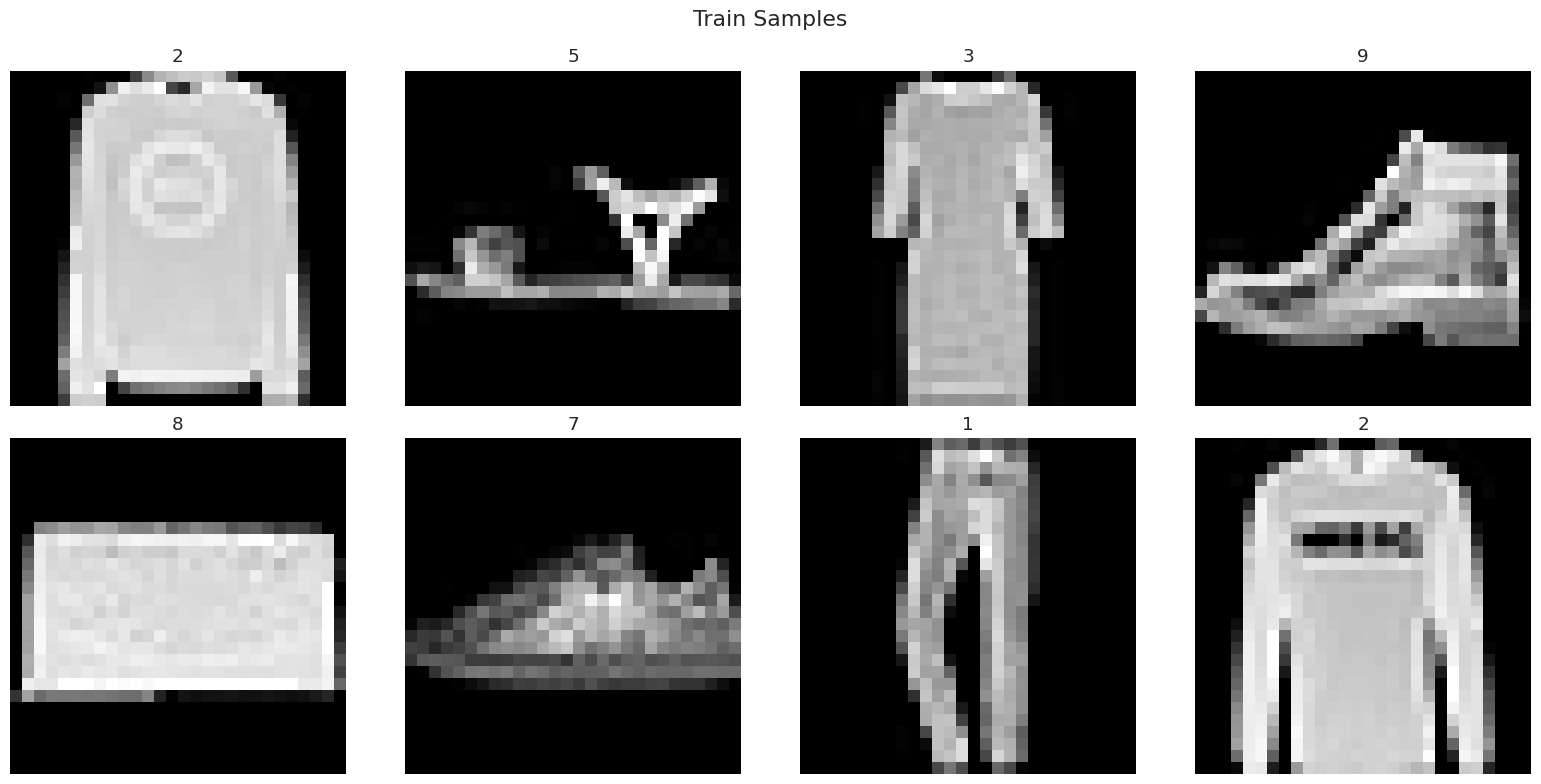

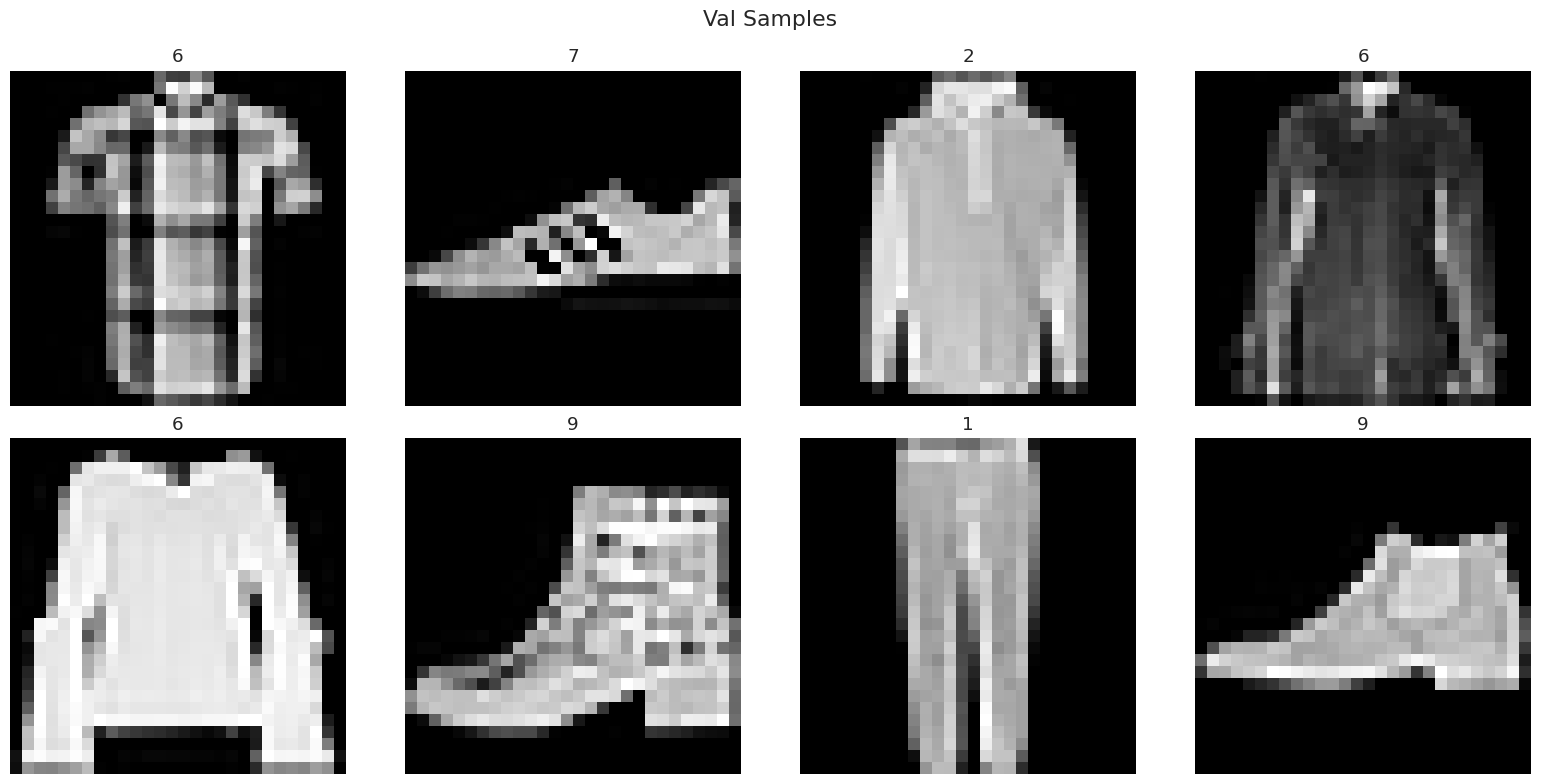

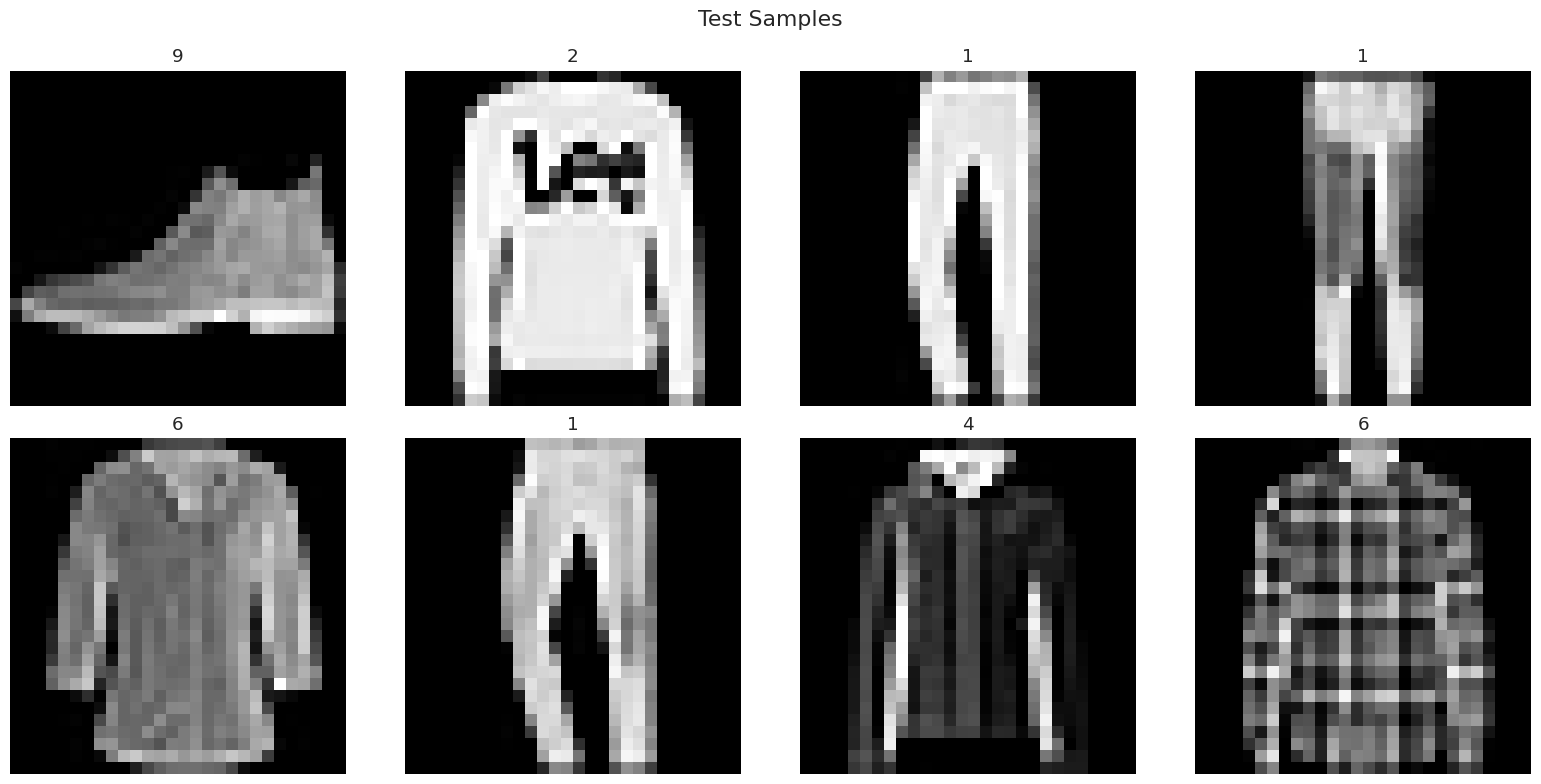

In [181]:
def get_transforms(augment=True):
    transforms = [ToTensor(), Normalize((0.2860,), (0.3530,))]
    if augment:
        transforms.insert(0, RandomHorizontalFlip(p=0.5))
        transforms.insert(0, RandomRotation(10))
    return Compose(transforms)

def show_samples(loader, title):
    images, labels = next(iter(loader))
    _, axes = plt.subplots(2, 4, figsize=(16, 8))
    for ax, img, label in zip(axes.ravel(), images[:18], labels[:18]):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(label.item())
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

full_training_set = FashionMNIST(
    root=DATASET_PATH,
    download=True,
    train=True,
    transform=get_transforms(augment=True))
testing_set = FashionMNIST(
    root=DATASET_PATH,
    download=True,
    train=False,
    transform=get_transforms(augment=False))

train_indices, val_indices = train_test_split(
    range(len(full_training_set)),
    test_size=VAL_SIZE,
    random_state=RANDOM_SEED,
    shuffle=True,
    stratify=full_training_set.targets.numpy())

training_set = Subset(full_training_set, train_indices)
validation_set = Subset(full_training_set, val_indices)
validation_set.dataset.transform = get_transforms(augment=False)

train_loader = DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
val_loader = DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)
test_loader = DataLoader(testing_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

print(f"Train: {len(training_set)}, Val: {len(validation_set)}, Test: {len(testing_set)}")
show_samples(train_loader, "Train Samples")
show_samples(val_loader, "Val Samples")
show_samples(test_loader, "Test Samples")

### Реализация оптимизатора Adam
Адам - это популярный алгоритм оптимизации, используемый для обновления weights and biases нейронной сети во время обучения.

In [182]:
class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, 
                 weight_decay=0, amsgrad=False):
        defaults = dict(lr=lr, betas=betas, eps=eps, 
                       weight_decay=weight_decay, amsgrad=amsgrad)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad
                state = self.state[p]
                
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p)
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    if group['amsgrad']:
                        state['max_exp_avg_sq'] = torch.zeros_like(p)

                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])

                state['step'] += 1
                beta1, beta2 = group['betas']

                state['exp_avg'].mul_(beta1).add_(grad, alpha=1-beta1)
                state['exp_avg_sq'].mul_(beta2).addcmul_(grad, grad, value=1-beta2)

                bias_corr1 = 1 - beta1 ** state['step']
                bias_corr2 = 1 - beta2 ** state['step']
                
                denom = (state['exp_avg_sq'].sqrt() / math.sqrt(bias_corr2)).add_(group['eps'])
                
                if group['amsgrad']:
                    torch.maximum(state['max_exp_avg_sq'], state['exp_avg_sq'], out=state['max_exp_avg_sq'])
                    denom = (state['max_exp_avg_sq'].sqrt() / math.sqrt(bias_corr2)).add_(group['eps'])

                step_size = group['lr'] / bias_corr1
                p.addcdiv_(state['exp_avg'], denom, value=-step_size)

        return loss

In [183]:
class ILayer(nn.Module, ABC):
    @abstractmethod
    def forward(self, x):
        pass
    
    @abstractmethod
    def backward(self, grad_output):
        pass

### Реализация слоёв нейронной сети

Код включает два основных типа слоёв:  
1. **Полносвязный (FullyConnected)**  
2. **Активации ReLU**  

**Функционал:**  
- Поддержка прямого (`forward`) и обратного (`backward`) проходов.  
- Соответствует требованиям задачи.

In [184]:
class FullyConnected(ILayer):
    weight: nn.Parameter
    bias: nn.Parameter
    input: None | Any

    def __init__(self, in_features, out_features, dtype=torch.float32):
        super().__init__()
        self.weight = nn.Parameter(torch.empty((in_features, out_features), dtype=dtype))
        self.bias = nn.Parameter(torch.empty(out_features, dtype=dtype))
        self.input = None
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_normal_(self.weight, mode='fan_in', nonlinearity='relu')
        nn.init.constant_(self.bias, 0)
    
    def forward(self, x):
        self.input = x
        return x @ self.weight + self.bias
    
    def backward(self, grad_output):
        assert self.input != None

        grad_input = grad_output @ self.weight.T
        grad_weight = self.input.T @ grad_output
        grad_bias = grad_output.sum(dim=0)
        return grad_input, grad_weight, grad_bias

class Relu(ILayer):
    mask: Any | None

    def __init__(self):
        super().__init__()
        self.mask = None

    def forward(self, x):
        self.mask = x > 0
        return x * self.mask
    
    def backward(self, grad_output):
        assert self.mask != None

        return grad_output * self.mask

### Реализация Lightning-модели (LitModel)

Класс `LitModel` на основе `LightningModule` инкапсулирует логику обучения/валидации/тестирования нейросети.

**Ключевые компоненты:**
- **Архитектура:**  
  Пользовательская сеть `MyNeuralNetwork` с параметрами:  
  - `hidden_size` — размер скрытого слоя  
  - `batch_normalization` — флаг применения BatchNorm  

- **Оптимизатор:**  
  - Поддержка L2-регуляризации через `weight_decay`  
  - Настраиваемый `learning_rate`  

- **Функция потерь:**  
  `CrossEntropyLoss` (стандартная для классификации)  

- **Валидация градиентов:**  
  Численная проверка (`_validate_gradients`) методом конечных разностей:  
  - Сравнение аналитических и численных градиентов  
  - Предупреждение при расхождении > `1e-3` (контроль ошибок обратного распространения)

In [185]:
class NeuralNetwork(nn.Module):
    def __init__(self, hidden_size=256, batch_norm=False, input_size=784, output_size=10):
        super().__init__()
        self.fc1 = FullyConnected(input_size, hidden_size)
        self.relu = Relu()
        self.bn = nn.BatchNorm1d(hidden_size) if batch_norm else nn.Identity()
        self.fc2 = FullyConnected(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.bn(x)
        return self.fc2(x)


class LitModel(L.LightningModule):
    _EPS = 1e-4
    _GRAD_CHECK_INTERVAL = 100
    _OPTIMIZERS = {
            'SGD': SGD,
            'Adam': Adam,
            'RMSprop': RMSprop
        }
    _SGD_MOMENTUM = 0.9
    _RMSPROP_ALPHA = 0.99


    def __init__(self, hidden_size=256, batch_norm=False, optimizer_name='adam', lr=1e-3, weight_decay=0.005):
        super().__init__()
        self.save_hyperparameters('optimizer_name', 'lr', 'weight_decay')
        self.model = NeuralNetwork(hidden_size, batch_norm)
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        def _validate_gradients(x, y):
            original_params = {n: p.detach().clone() for n, p in self.model.named_parameters()}
            
            for name, param in self.model.named_parameters():
                if param.grad is None:
                    continue
                    
                analytic_grad = param.grad.data.clone()
                numerical_grad = torch.zeros_like(param.data)
                
                for i in range(param.numel()):
                    param.data.view(-1)[i] += self._EPS
                    loss_plus = F.cross_entropy(self.model(x), y).item()
                    
                    param.data.view(-1)[i] -= 2 * self._EPS
                    loss_minus = F.cross_entropy(self.model(x), y).item()
                    
                    param.data.view(-1)[i] += self._EPS
                    
                    numerical_grad.view(-1)[i] = (loss_plus - loss_minus) / (2 * self._EPS)
                
                grad_diff = torch.norm(analytic_grad - numerical_grad) / (
                    torch.norm(analytic_grad) + torch.norm(numerical_grad) + 1e-8)
                
                if grad_diff > 1e-3:
                    print(f"WARNING: Large gradient difference in {name}: {grad_diff.item():.4f}")
            
            for n, p in self.model.named_parameters():
                p.data.copy_(original_params[n])

        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss, on_step=True)

        if batch_idx % self._GRAD_CHECK_INTERVAL == 0:
            _validate_gradients(x, y)
            
        return loss

    @staticmethod
    def _calc_accuracy(model, batch):
        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = model(x)
        return (y_hat.argmax(dim=1) == y).float().mean()
    
    @staticmethod
    def _calc_loss(model, batch):
        x, y = batch
        x = x.view(x.size(0), -1)
        y_hat = model(x)
        return F.cross_entropy(y_hat, y)

    def validation_step(self, batch):
        self.log(
            'val_acc', 
            self._calc_accuracy(self.model, batch), 
            on_step=False, 
            on_epoch=True,
        )
        self.log(
            'val_loss', 
            self._calc_loss(self.model, batch), 
            on_step=False, 
            on_epoch=True,
        )
    
    def test_step(self, batch):
        self.log(
            'test_acc', 
            self._calc_accuracy(self.model, batch), 
            on_step=False, 
            on_epoch=True
        )
    
    def configure_optimizers(self):
        optimizer = self._OPTIMIZERS[self.hparams.optimizer_name]
        params = {
            'params': self.parameters(),
            'lr': self.hparams.lr,
            'weight_decay': self.hparams.weight_decay
        }
        
        if self.hparams.optimizer_name == 'SGD':
            params['momentum'] = self._SGD_MOMENTUM
        elif self.hparams.optimizer_name == 'RMSprop':
            params['alpha'] = self._RMSPROP_ALPHA
            
        return optimizer(**params)
    
    

In [ ]:
# LEARNING CONSTANTS
HP_FINDING_EPOCHS = 3
LEARNING_EPOCHS = 15
ACCELERATOR = "cpu"
LOGGER_DIR = "logs"

def train_all(name, epochs, hparams):
    for config in hparams:

        train_loader, val_loader, test_loader = (
            DataLoader(prepared_set, 4096, num_workers=WORKERS, shuffle=shaf_opt) for (prepared_set, shaf_opt) in [
                (training_set, True), 
                (validation_set, False), 
                (testing_set, False)
            ]
        )

        optimizer_name, lr, hidden_size, batch_normalization = config
        
        print(f"\nTraining with: {optimizer_name}, lr={lr:.0e}, hidden_size={hidden_size}, batch_norm={batch_normalization}")

        model = LitModel(
            hidden_size=hidden_size,
            batch_norm=batch_normalization,
            optimizer_name=optimizer_name,
            lr=lr,
        )

        logger = CSVLogger(LOGGER_DIR, name=name)

        logger.log_hyperparams({
            "max_epochs": epochs,
            "lr": lr,
            "optimizer": optimizer_name,
            "hidden_size": hidden_size,
            "batch_normalization": batch_normalization,
        })
        
        trainer = L.Trainer(
            max_epochs=epochs,
            accelerator=ACCELERATOR,
            logger=logger,
            log_every_n_steps=5,
            enable_model_summary=False,
            enable_progress_bar=False,
        )
        
        trainer.validate(model, dataloaders=val_loader, verbose=True)
        trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
        trainer.test(model, dataloaders=test_loader)

### Подбор гиперпараметров

**Стратегия перебора:**
- Используется класс `HyperparameterGrid` для генерации всех комбинаций
- **Параметры:**
  - **Оптимизаторы:** Adagrad, Adam (наша реализация), RMSprop
  - **Learning rate:** 0.01 и 0.001
  - **Размер скрытого слоя:** 100 и 1000 нейронов
  - **Batch Normalization:** с BN и без BN

**Всего комбинаций:** 24 (3 × 2 × 2 × 2)

**Процесс подбора:**
1. **Первичная оценка:** Тестирование всех комбинаций на 3 эпохах
2. **Финальное обучение:** Лучшие конфигурации обучаются на 15 эпохах

In [ ]:
class HyperparameterGrid:
    _OPTIMIZERS = [
        'SGD',
        'Adam',
        'RMSprop',
    ]
    _LEARNING_RATES = [
        0.01,
        0.001,
    ]
    _HIDDEN_SIZES = [
        100,
        1000,
    ]
    _BATCH_NORM_OPTIONS = [
        True,
        False,
    ]
    
    def __init__(self):
        self.optimizers_names = [
            ('SGD', 'SGD'),
            ('Adam', 'Adam'),
            ('RMSprop', 'RMSprop'),
        ]
        self.learning_rates = [0.01, 0.001]
        self.hidden_sizes = [100, 1000]
        self.batch_norm_options = [False, True]
        
    def generate_configs(self):
        return list(itertools.product(
            self._OPTIMIZERS,
            self._LEARNING_RATES,
            self._HIDDEN_SIZES,
            self._BATCH_NORM_OPTIONS
        ))

hparams = HyperparameterGrid().generate_configs()
print(f"Total experiments to run: {len(hparams)}")
train_all("fashion_mnist_model", HP_FINDING_EPOCHS, hparams)


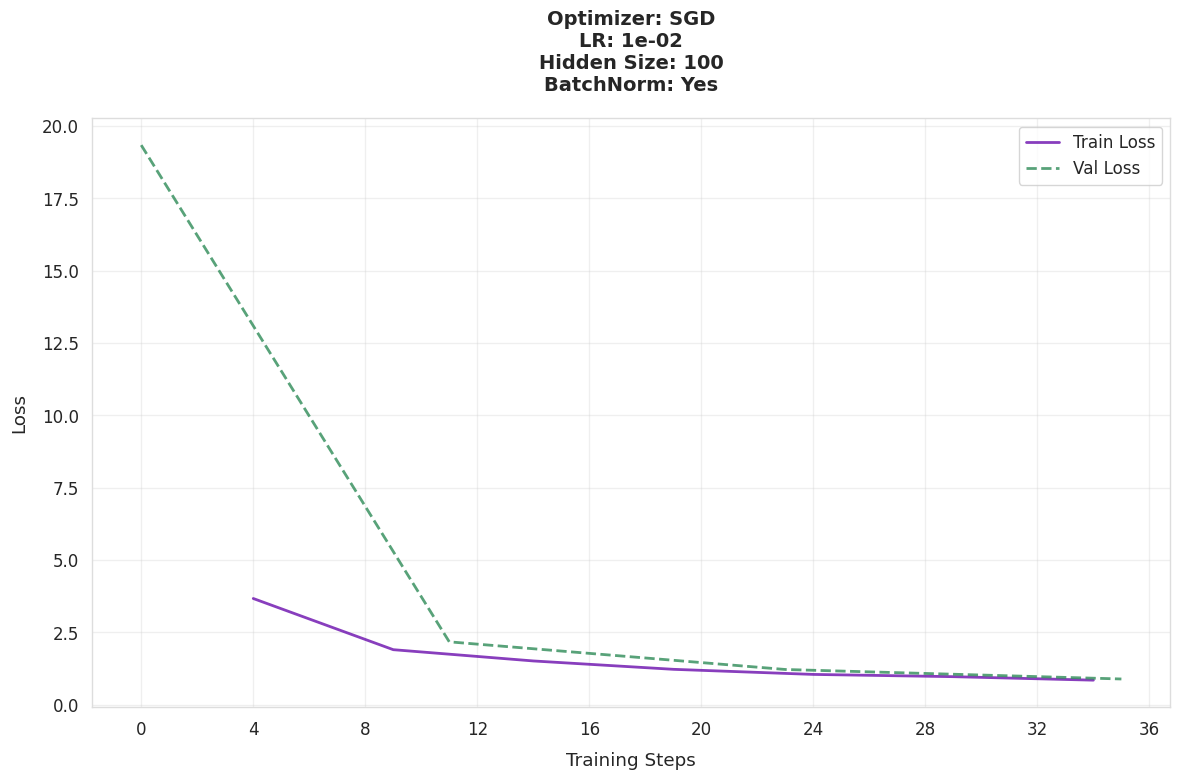

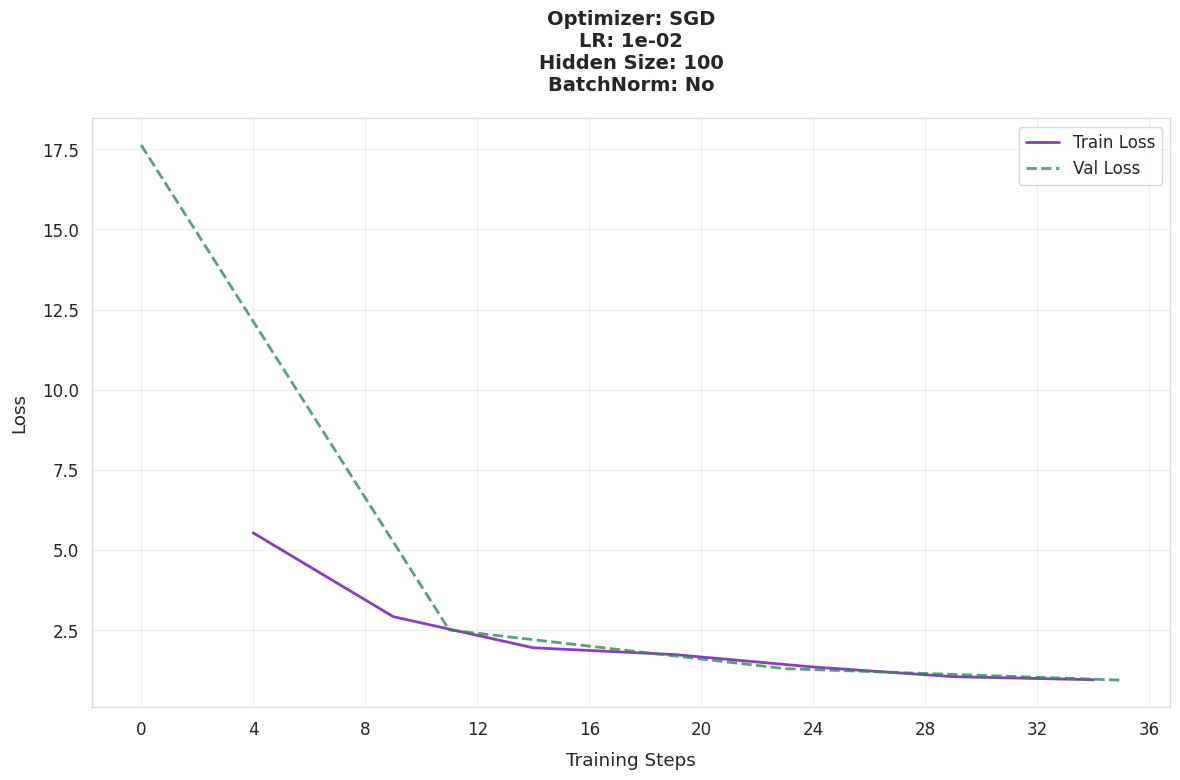

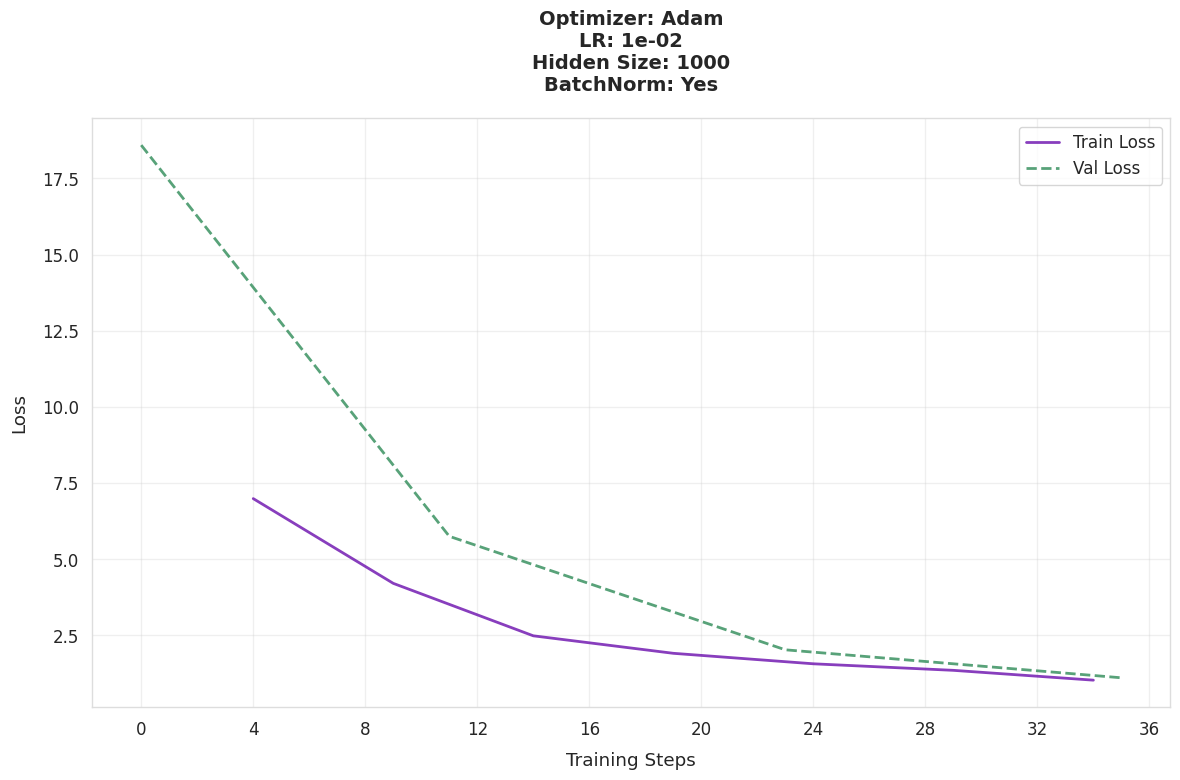

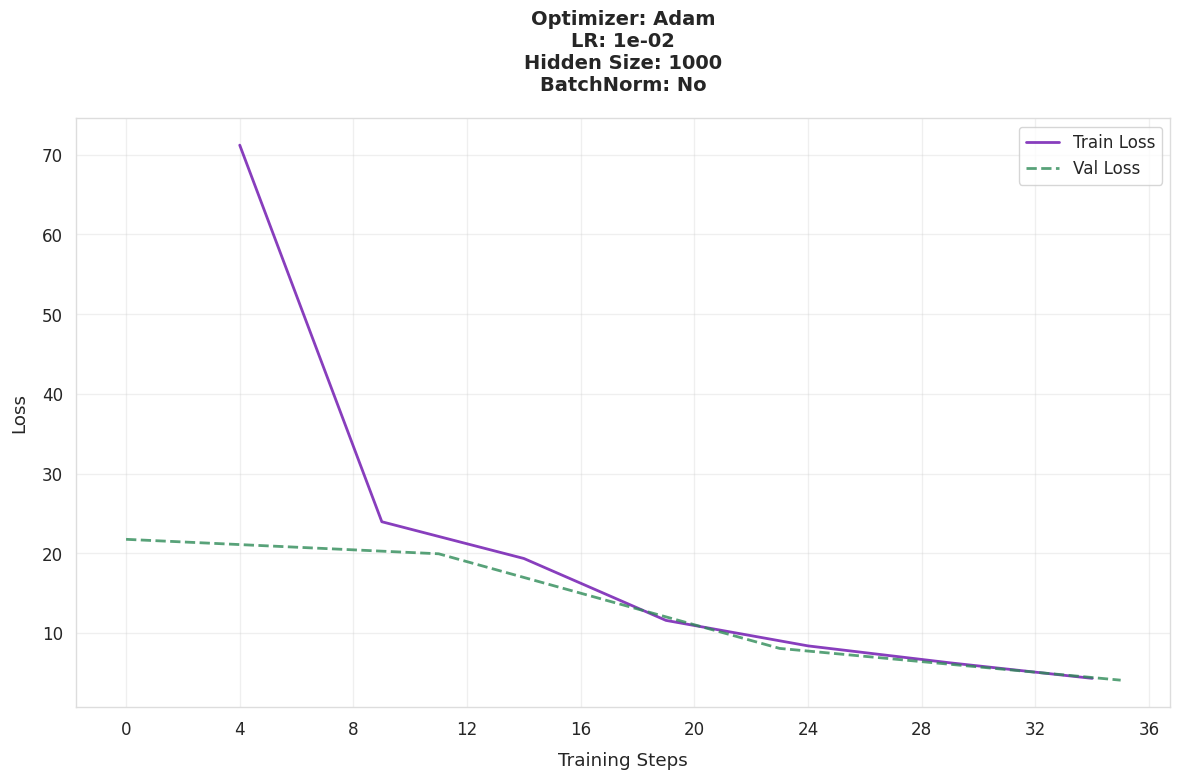

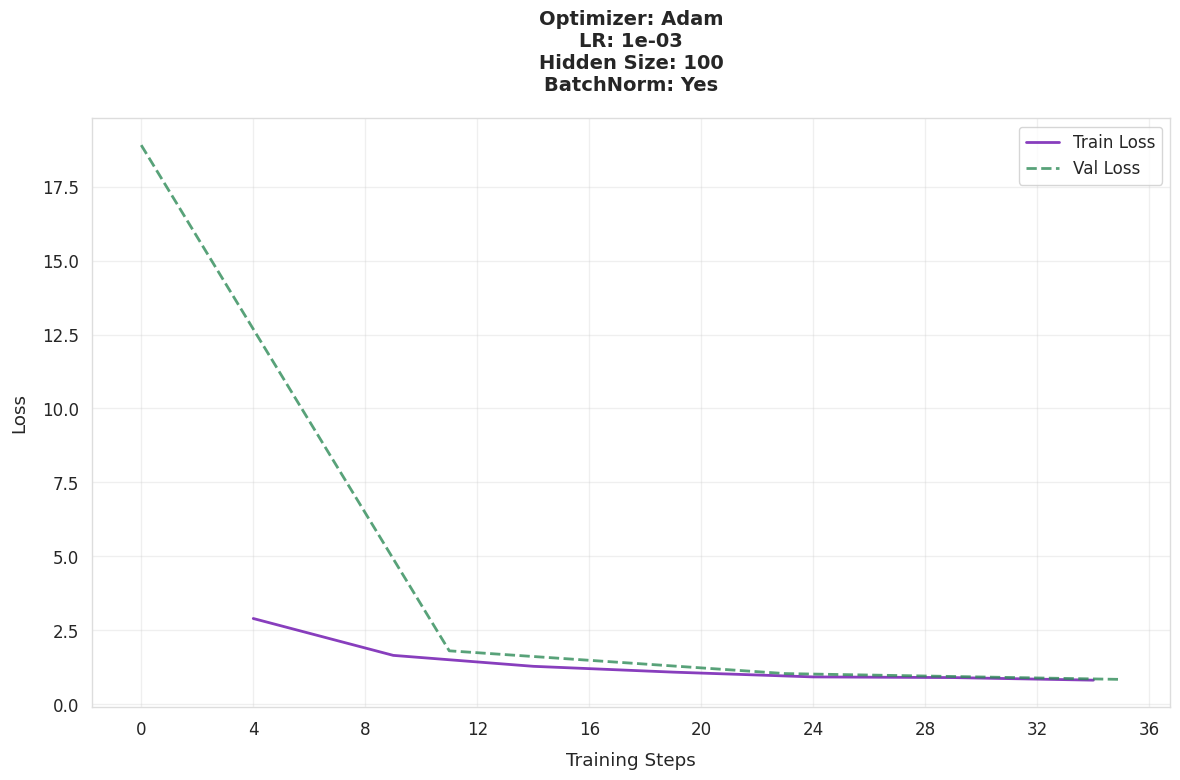

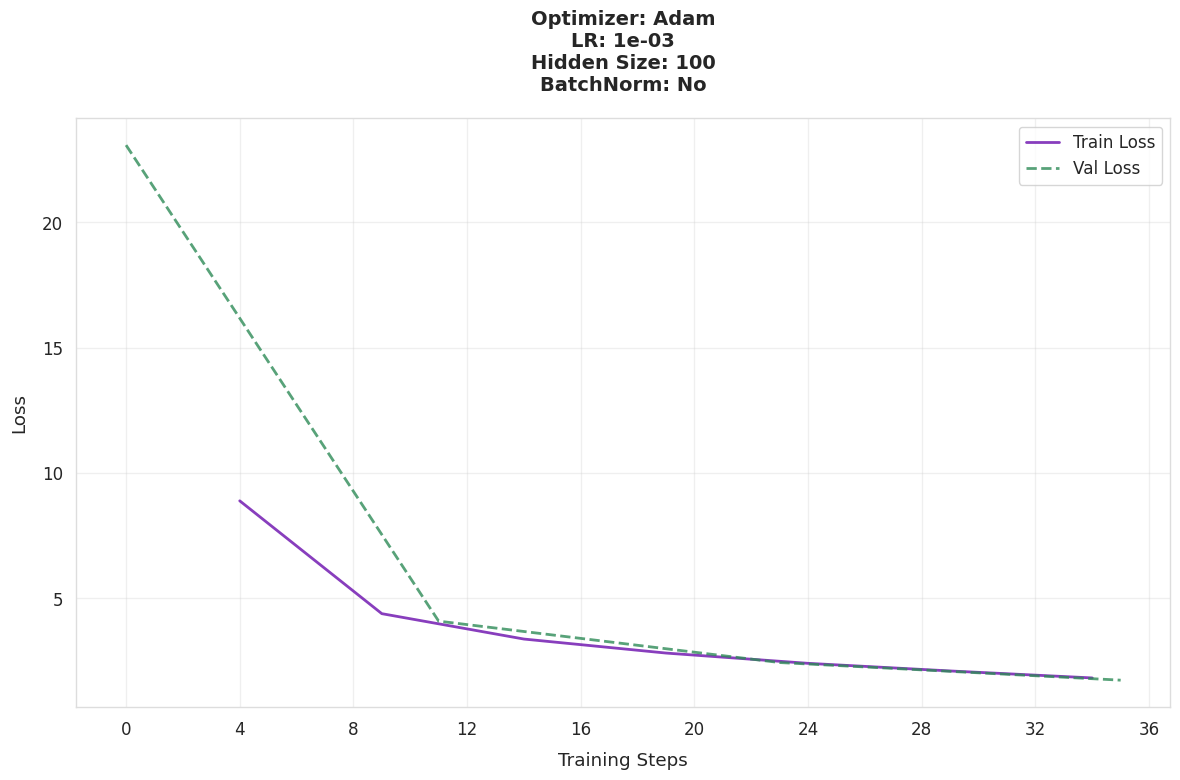

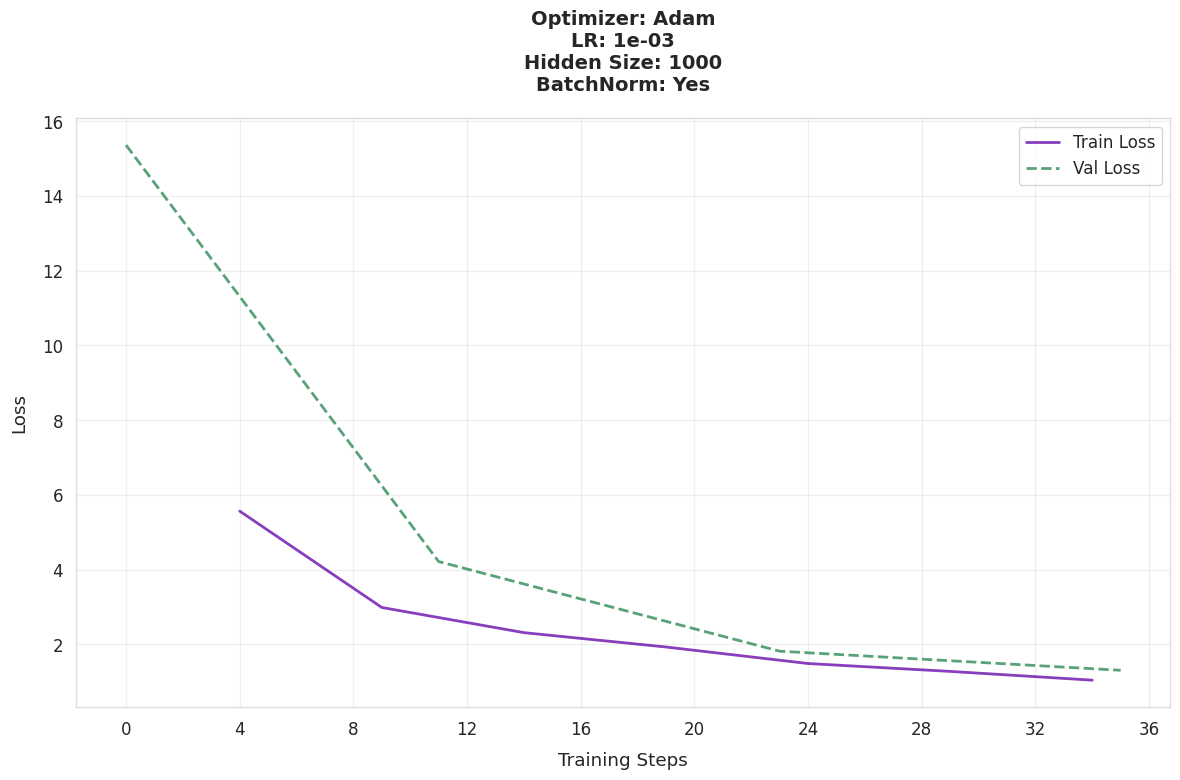

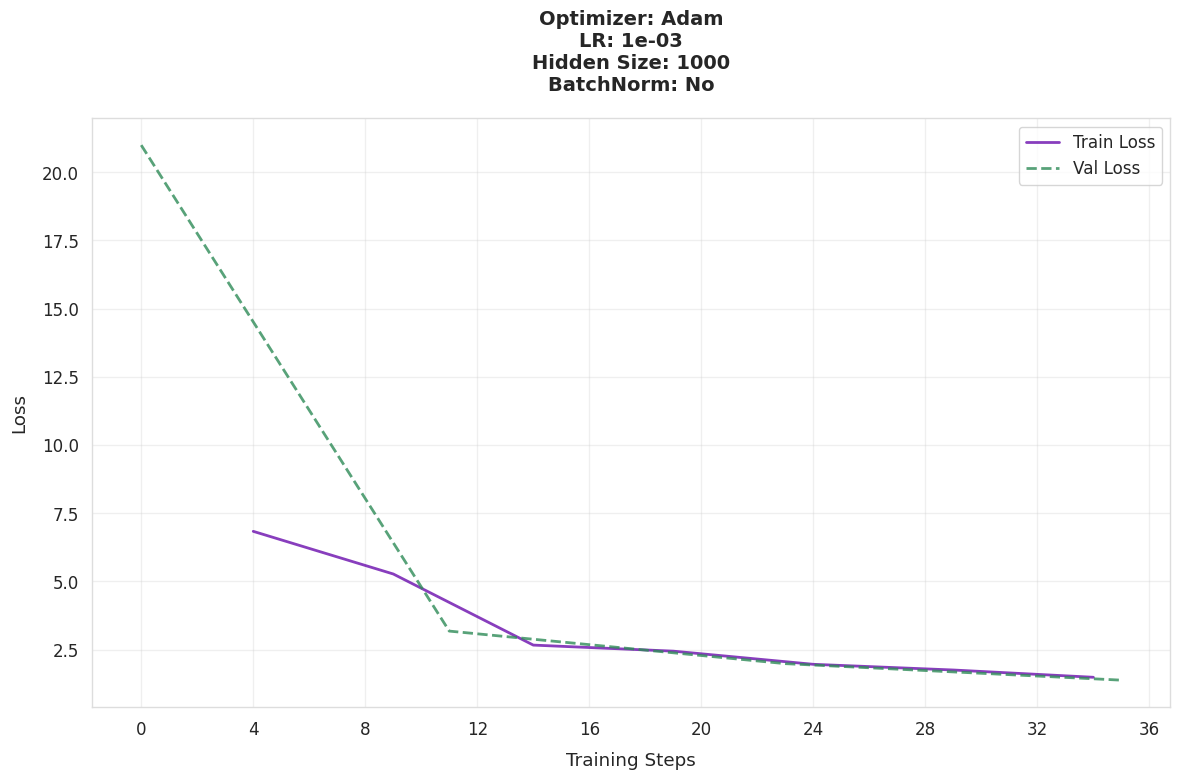

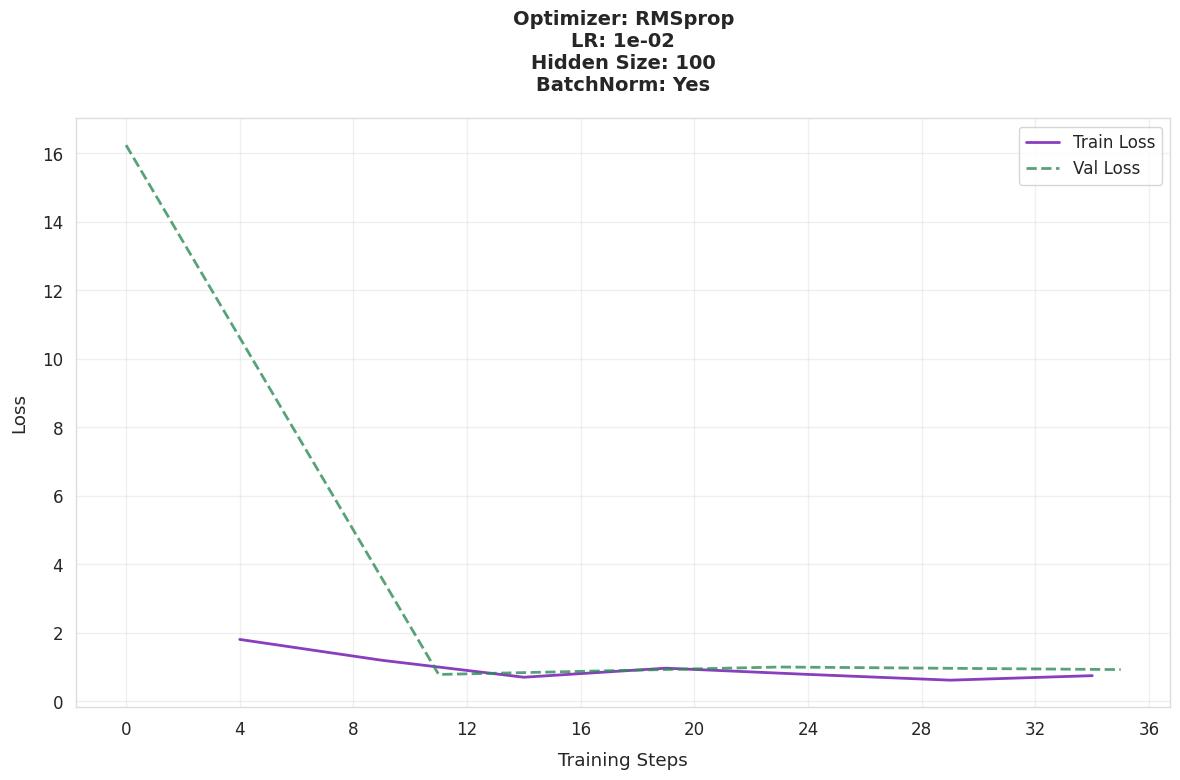

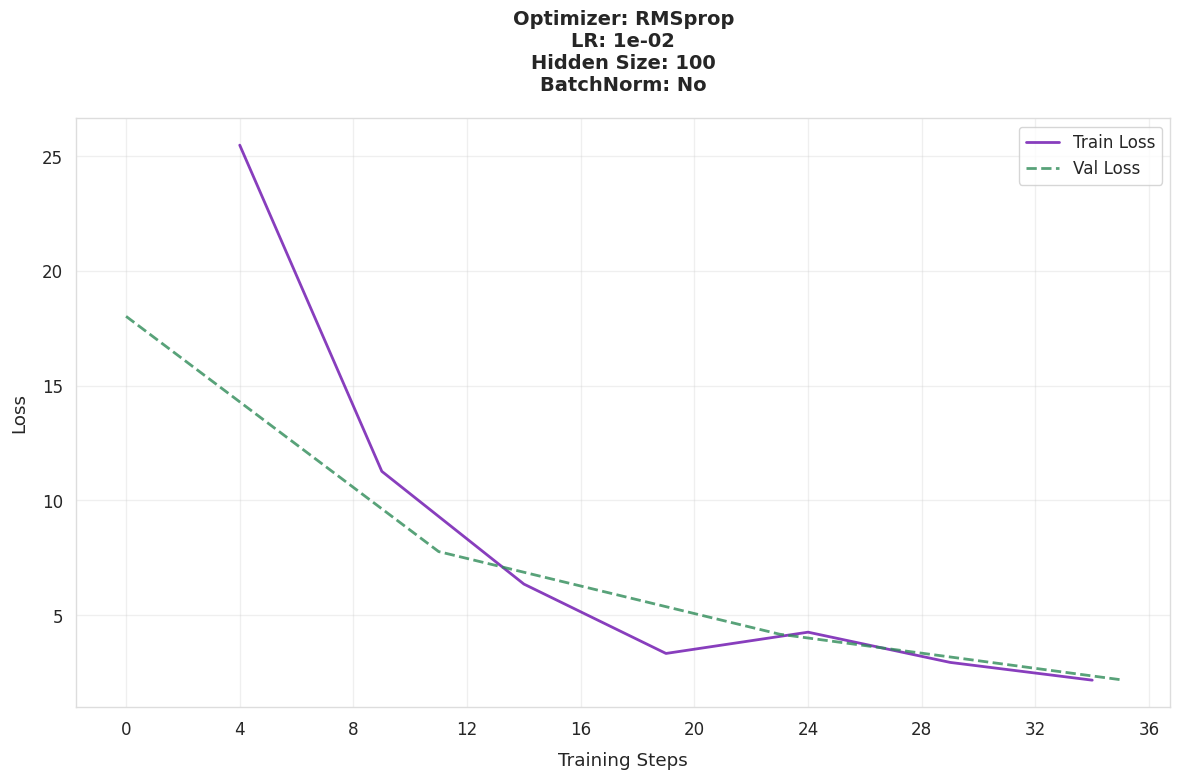

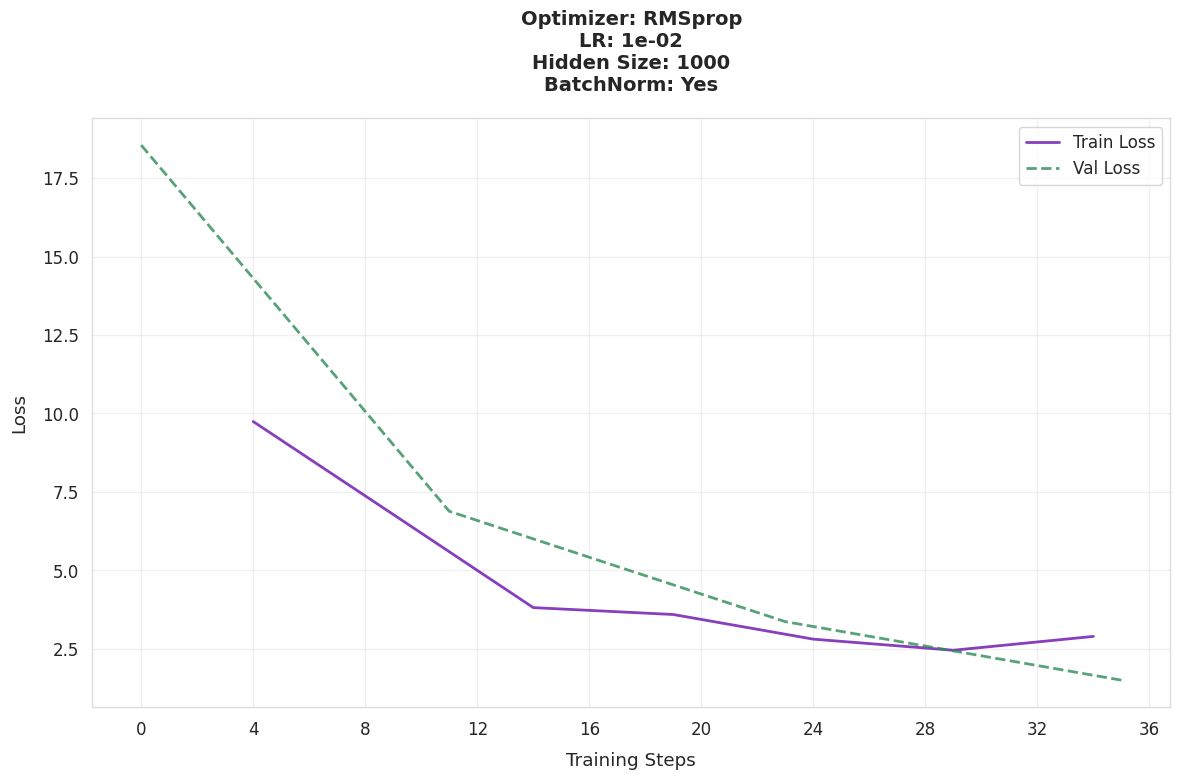

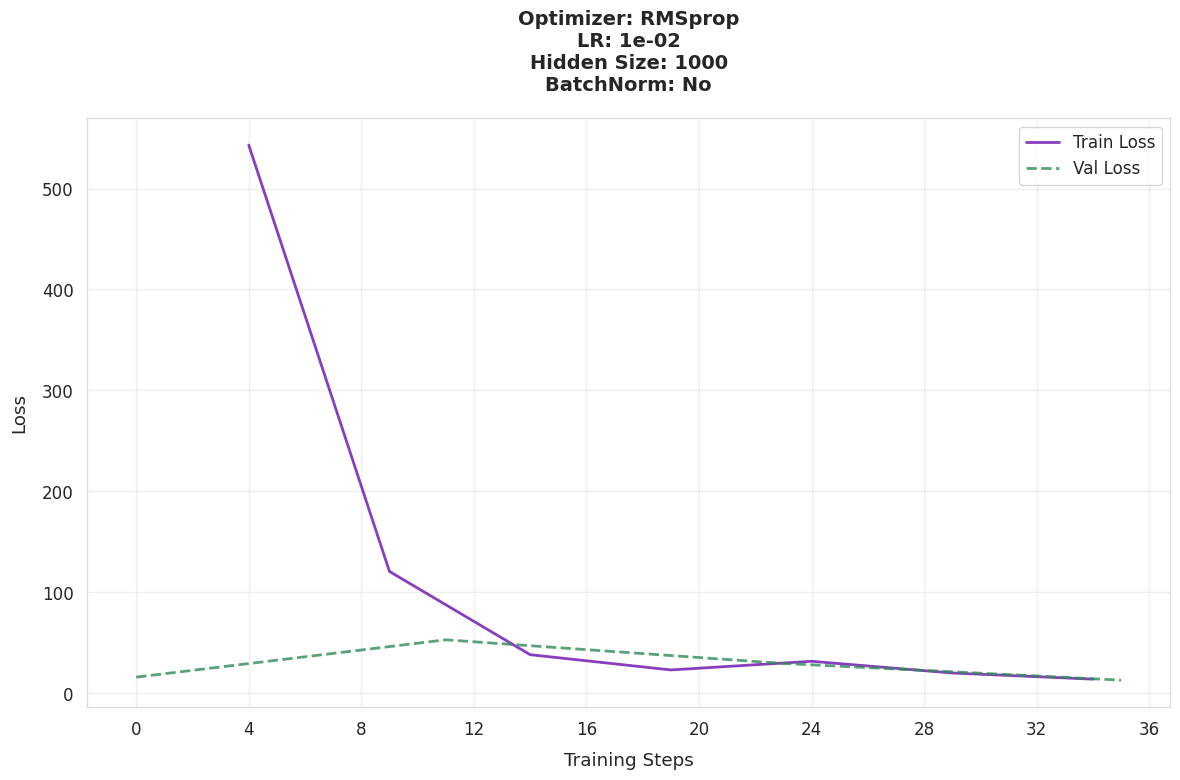

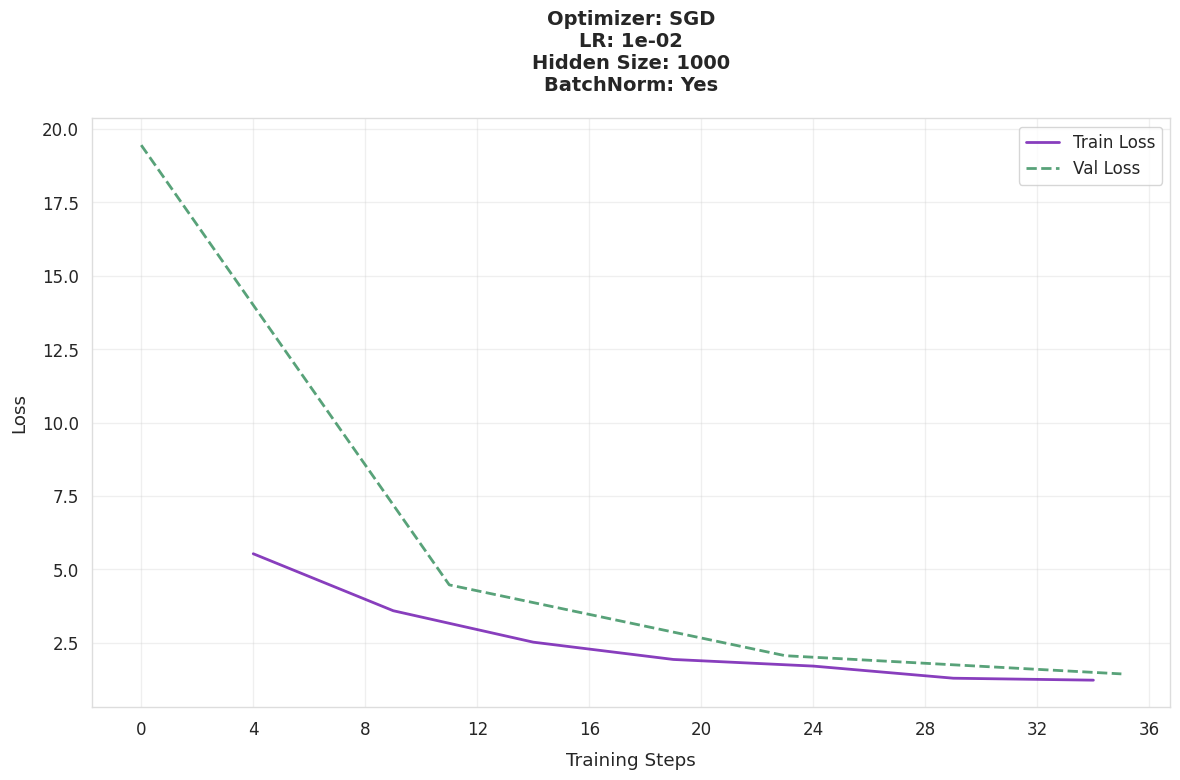

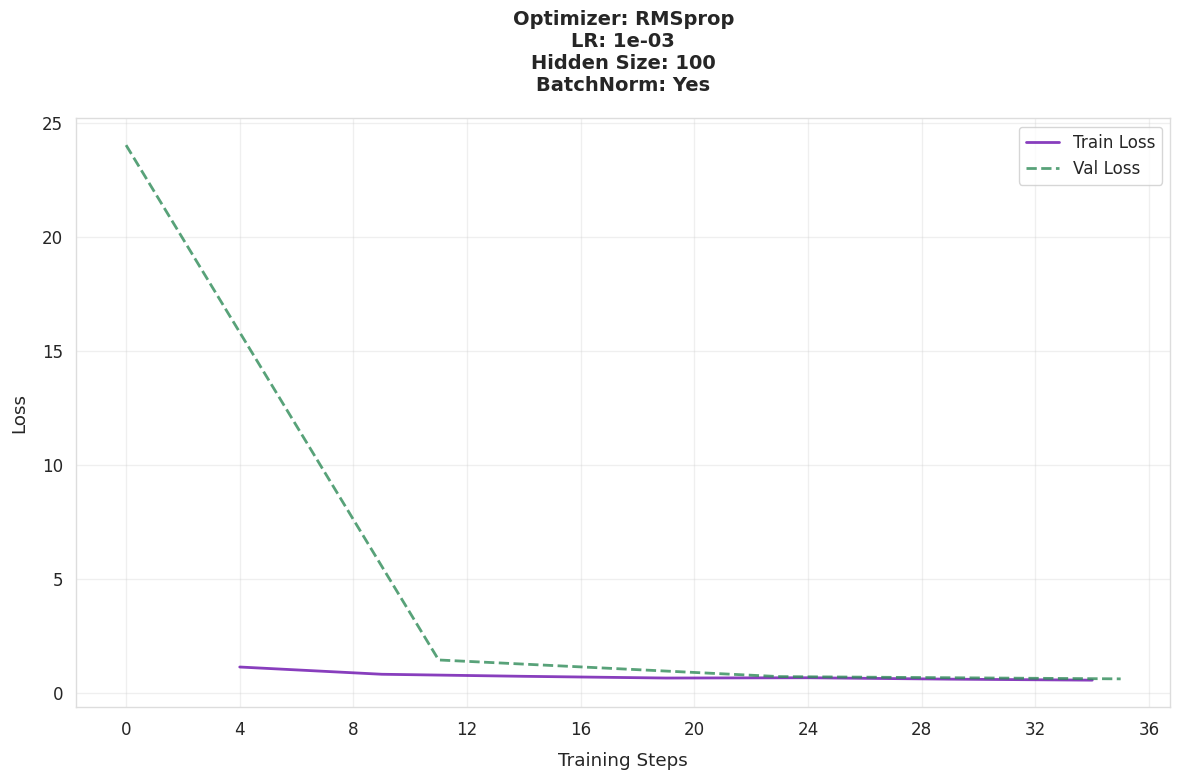

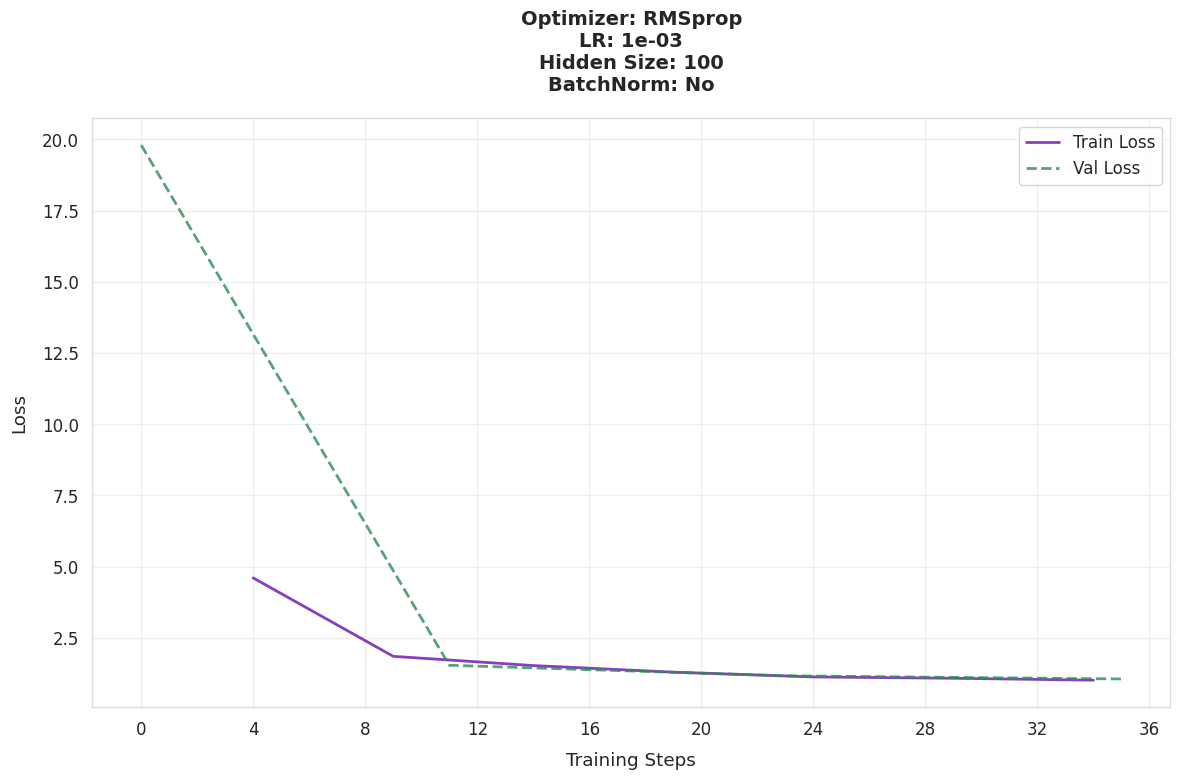

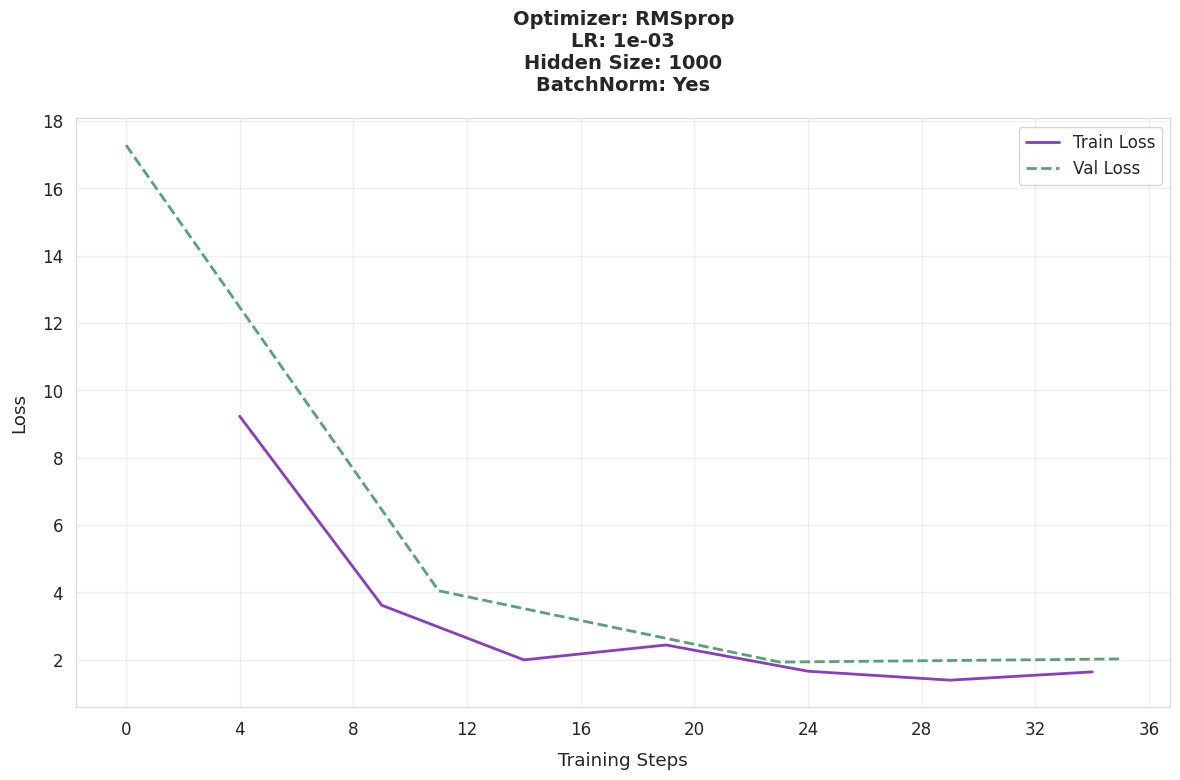

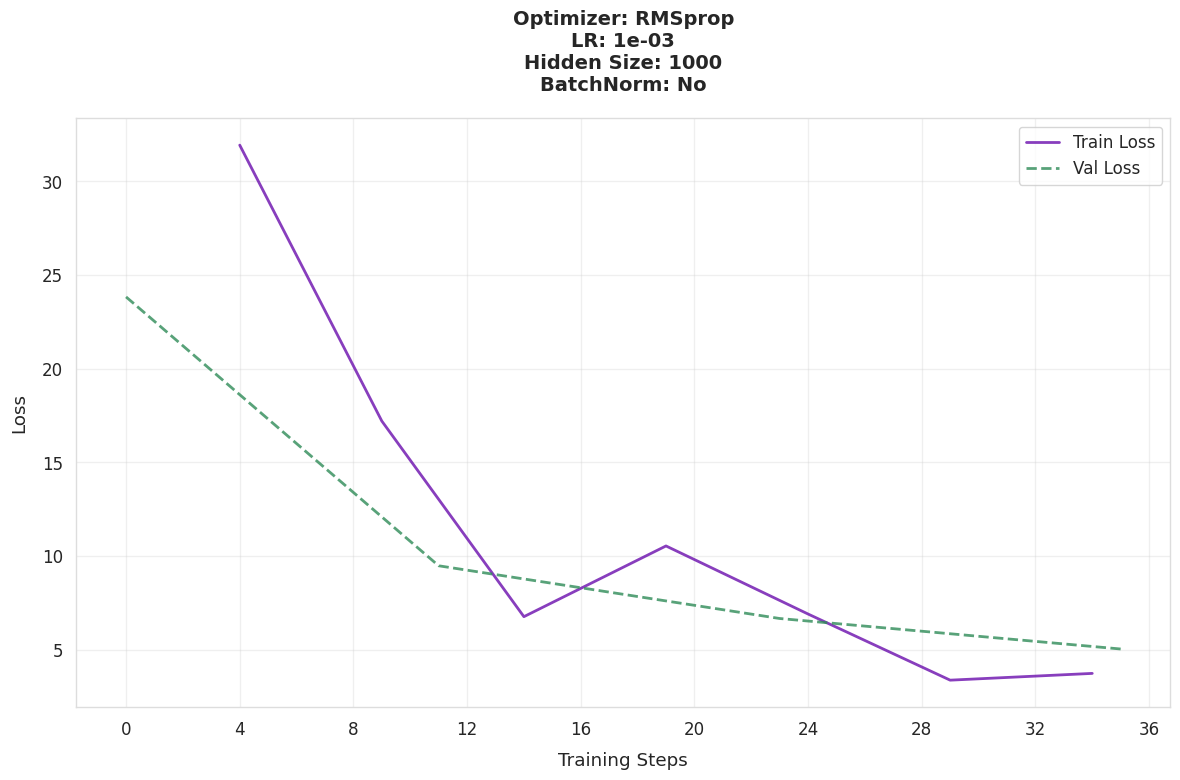

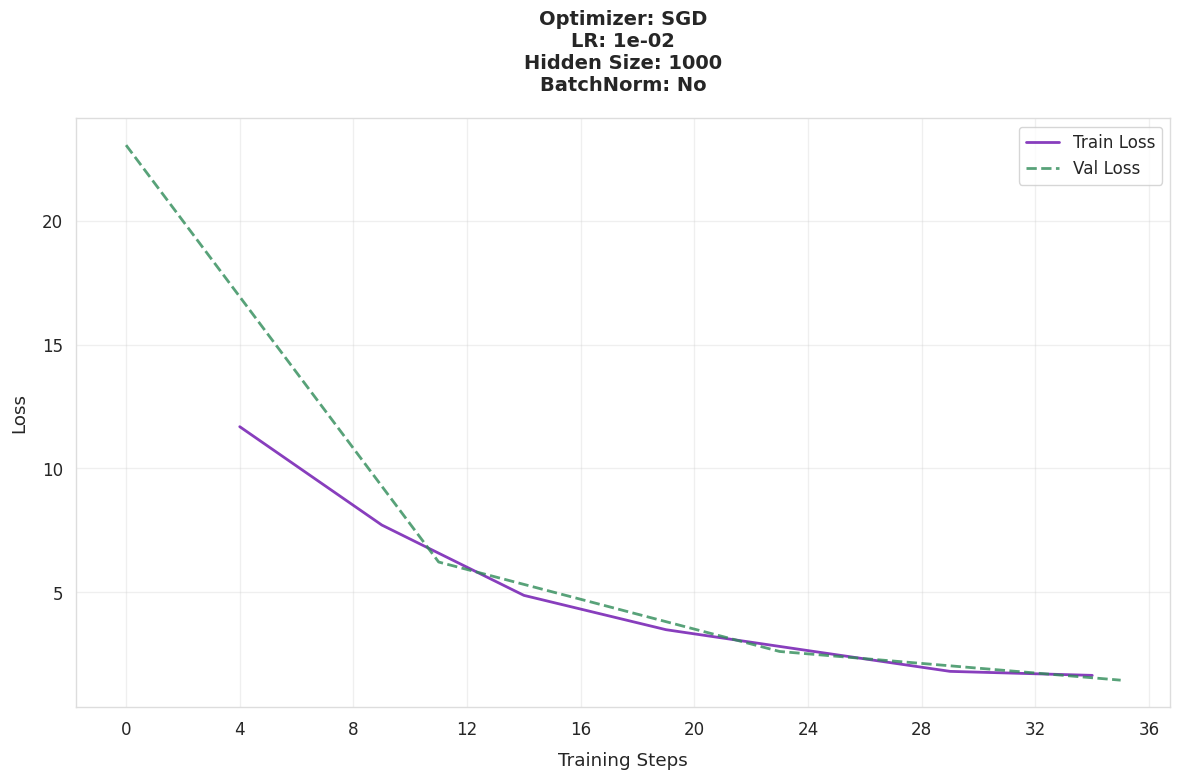

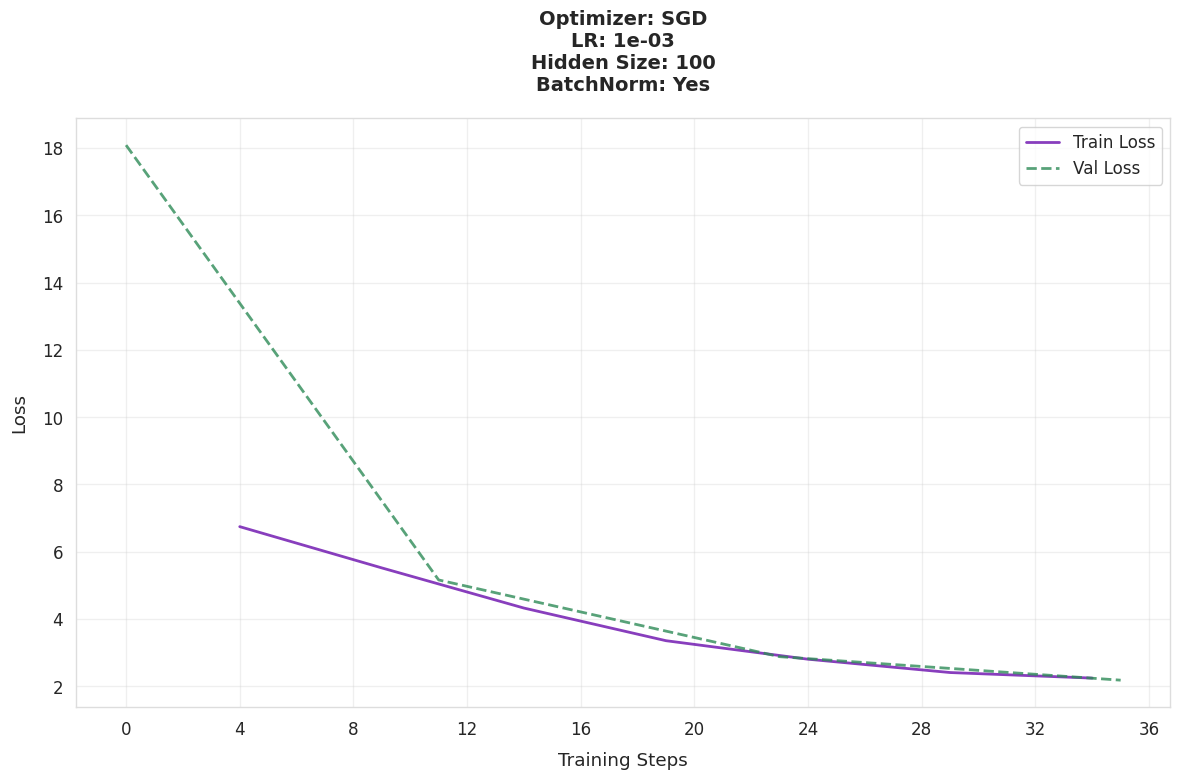

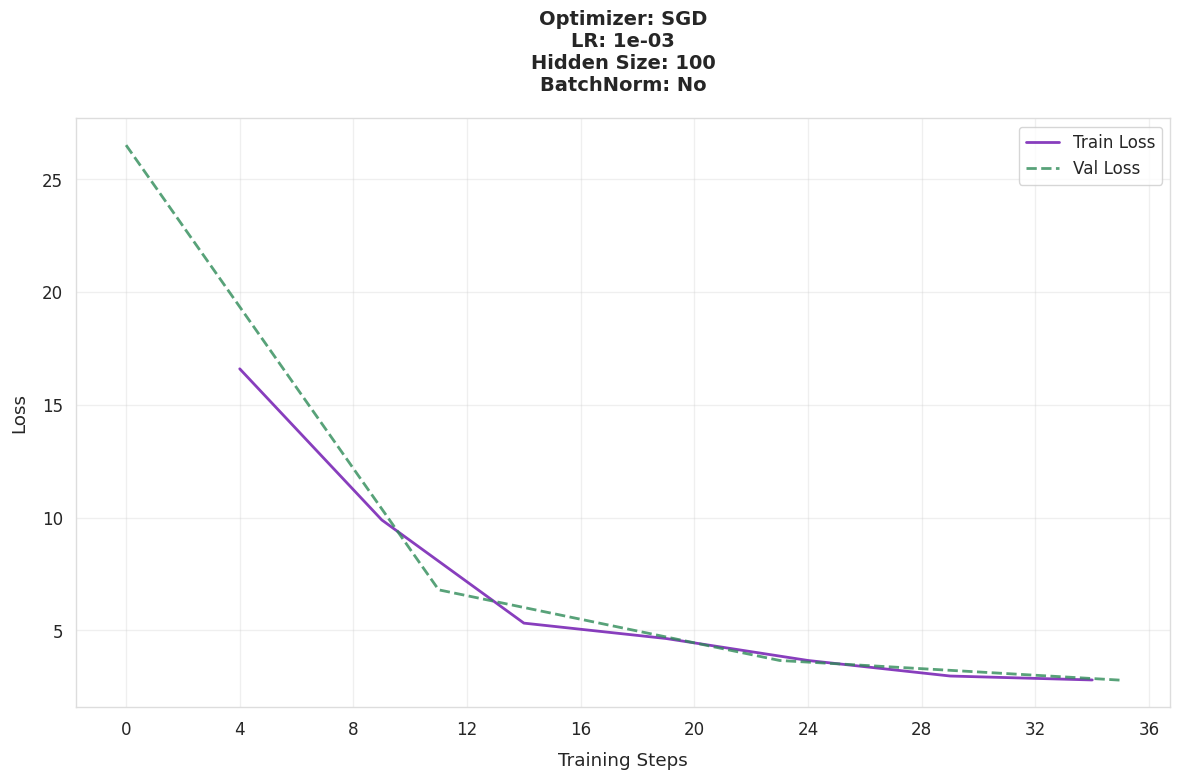

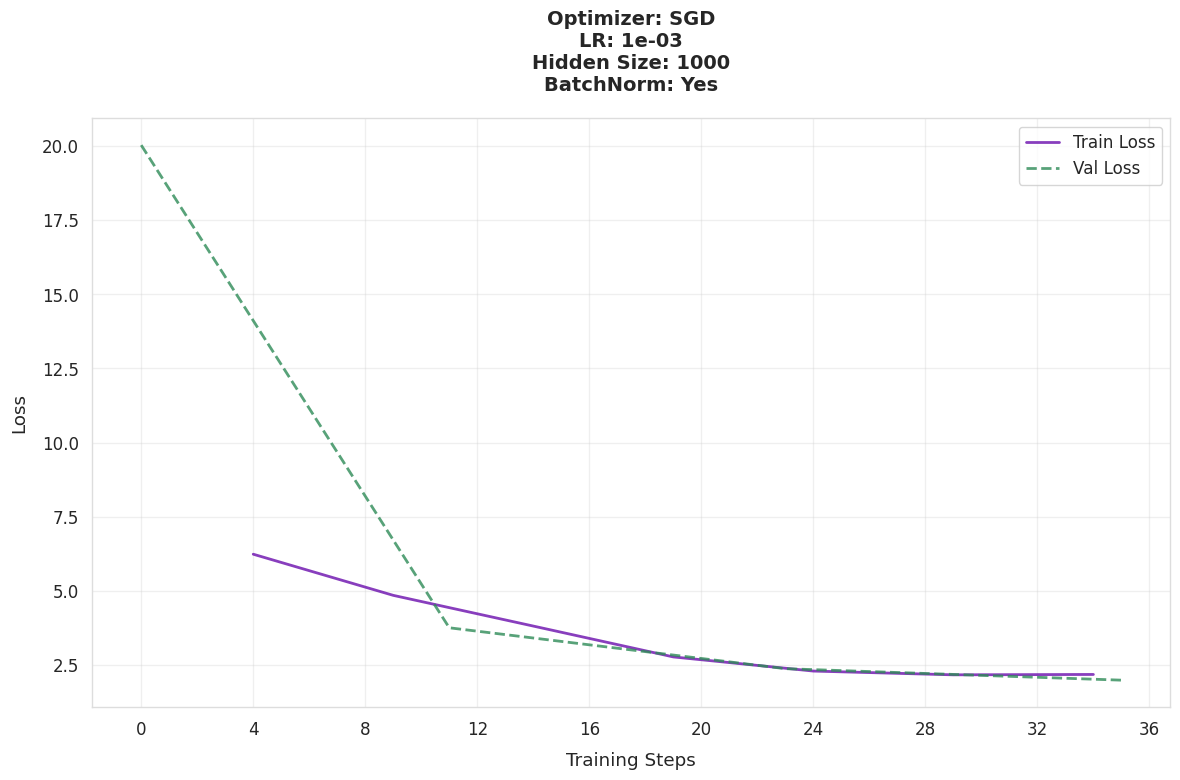

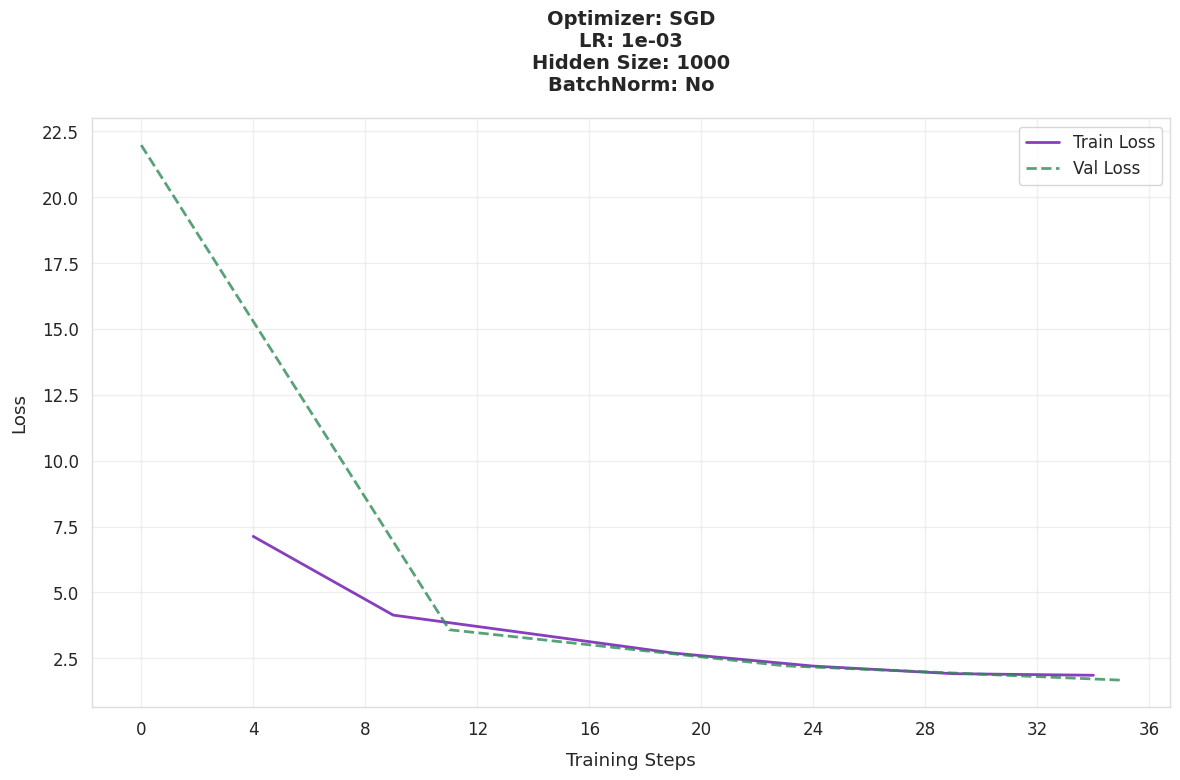

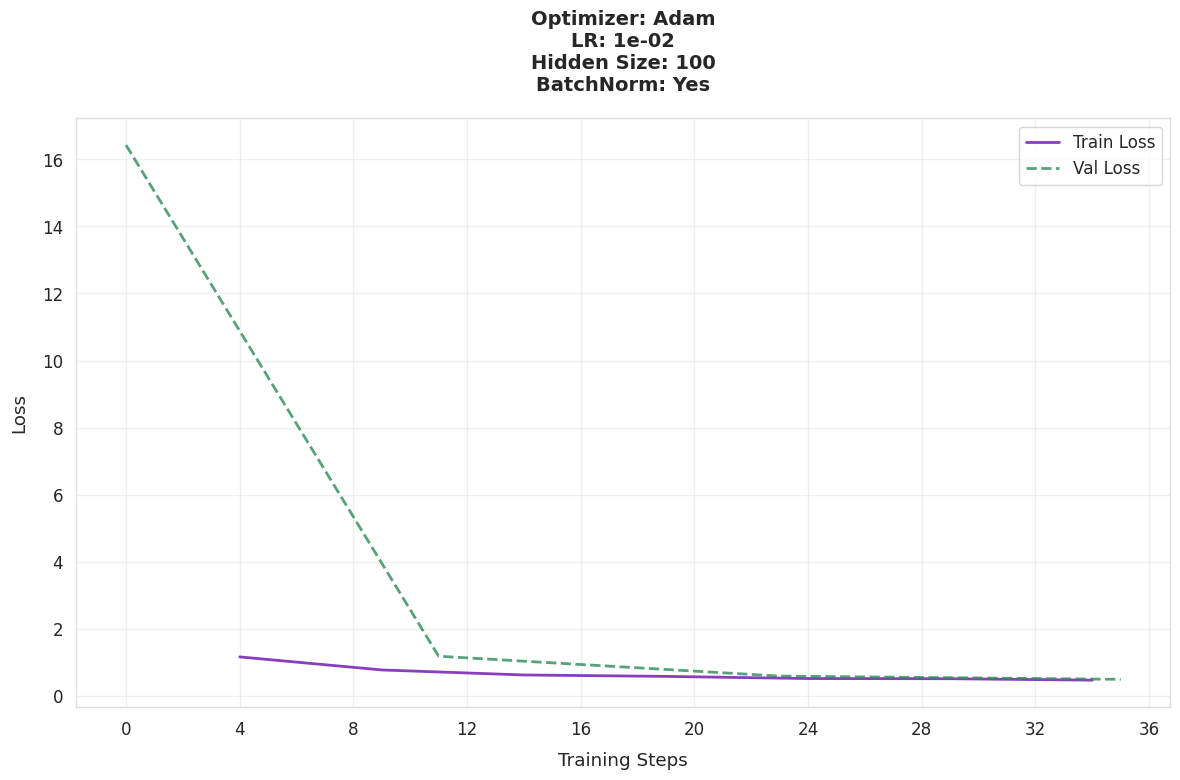

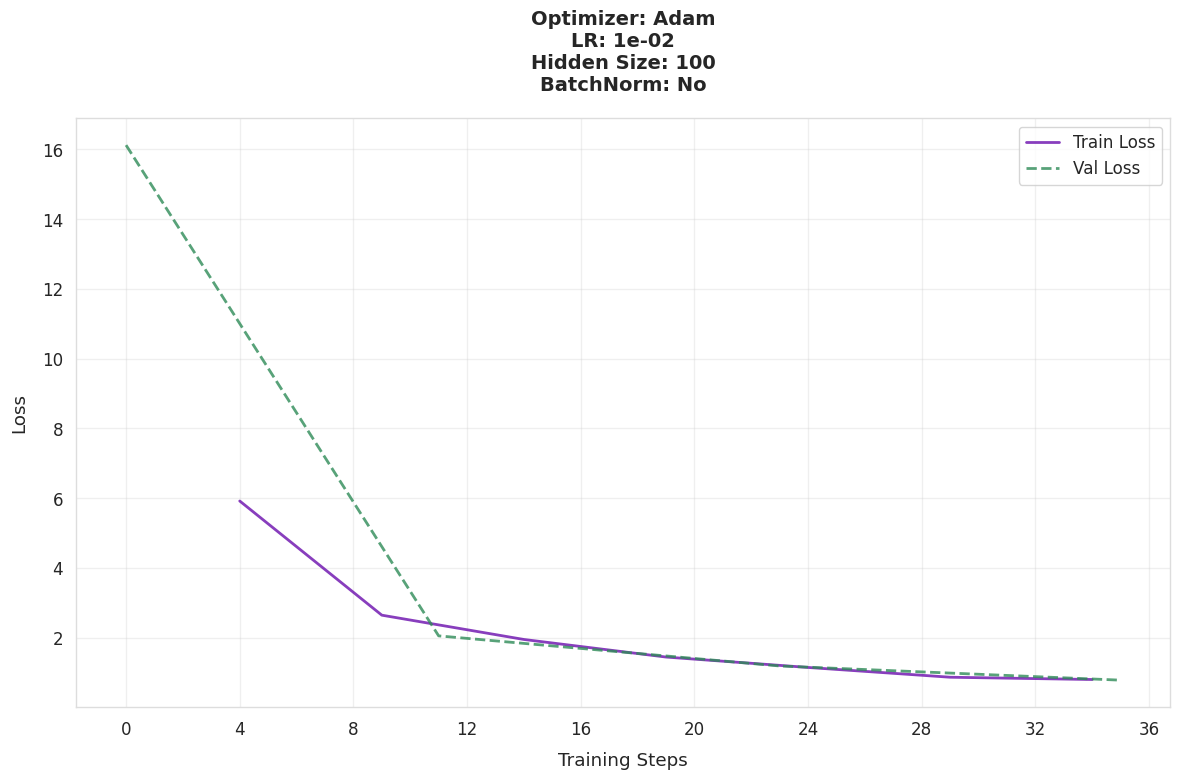


Val Acc Results:
+-----------+---------------+-------------+-----------+---------+
| Optimizer | Learning Rate | Hidden Size | BatchNorm | Val_Acc |
+-----------+---------------+-------------+-----------+---------+
|   Adam    |     1e-02     |    1000     |    Yes    | 0.8278  |
|    SGD    |     1e-02     |    1000     |    Yes    | 0.8271  |
|   Adam    |     1e-02     |     100     |    Yes    | 0.8271  |
|   Adam    |     1e-03     |    1000     |    Yes    | 0.8196  |
|   Adam    |     1e-03     |    1000     |    No     | 0.8173  |
|   Adam    |     1e-02     |    1000     |    No     | 0.8125  |
|    SGD    |     1e-02     |    1000     |    No     | 0.8091  |
|  RMSprop  |     1e-02     |    1000     |    Yes    | 0.8041  |
|  RMSprop  |     1e-03     |     100     |    Yes    | 0.7971  |
|    SGD    |     1e-03     |    1000     |    Yes    | 0.7970  |
|  RMSprop  |     1e-03     |    1000     |    Yes    | 0.7943  |
|  RMSprop  |     1e-02     |    1000     |    No     | 0.

In [193]:
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

LOSS_COLORS = {
    'train': '#6a0dad',
    'val': '#2e8b57'
}

def plot_individual_training_results(versions):
    for version in versions:
        plt.figure(figsize=(12, 8))
        df = pd.read_csv(os.path.join(version, "metrics.csv"))
        with open(os.path.join(version, "hparams.yaml")) as f:
            hparams = yaml.safe_load(f)
        
        train_df = df.dropna(subset=["train_loss"])
        val_df = df.dropna(subset=["val_loss"])
        
        plt.plot(
            train_df["step"],
            train_df["train_loss"],
            color=LOSS_COLORS['train'],
            linestyle='-',
            linewidth=2,
            alpha=0.8,
            label='Train Loss'
        )
        
        plt.plot(
            val_df["step"],
            val_df["val_loss"],
            color=LOSS_COLORS['val'],
            linestyle='--',
            linewidth=2,
            alpha=0.8,
            label='Val Loss'
        )
        
        title_parts = [
            f"Optimizer: {hparams['optimizer']}",
            f"LR: {hparams['lr']:.0e}",
            f"Hidden Size: {hparams['hidden_size']}",
            f"BatchNorm: {'Yes' if hparams['batch_normalization'] else 'No'}"
        ]
        plt.title("\n".join(title_parts), pad=20, fontsize=14, fontweight='bold')
        
        plt.xlabel("Training Steps", labelpad=10)
        plt.ylabel("Loss", labelpad=10)
        plt.legend(loc='upper right')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        
        for spine in plt.gca().spines.values():
            spine.set_visible(True)
            spine.set_edgecolor('#dddddd')
            spine.set_linewidth(1)
        
        plt.tight_layout()
        plt.show()

def print_results_table(versions, metric='test_acc'):
    table_data = []
    for version in versions:
        df = pd.read_csv(os.path.join(version, "metrics.csv")).dropna(subset=[metric])
        with open(os.path.join(version, "hparams.yaml")) as f:
            hparams = yaml.safe_load(f)
        
        best_metric = df[metric].max() if 'acc' in metric else df[metric].min()
        table_data.append([
            hparams['optimizer'],
            f"{hparams['lr']:.0e}",
            hparams['hidden_size'],
            'Yes' if hparams['batch_normalization'] else 'No',
            f"{best_metric:.4f}"
        ])
    
    reverse = True if 'acc' in metric or 'f1' in metric else False
    table_data.sort(key=lambda x: x[-1], reverse=reverse)

    print(f"\n{metric.replace('_', ' ').title()} Results:")
    print(tabulate(
        table_data,
        headers=['Optimizer', 'Learning Rate', 'Hidden Size', 'BatchNorm', metric.title()],
        tablefmt='pretty',
        floatfmt=".4f"
    ))


versions = sorted(glob("logs/fashion_mnist_model/*/"))

plot_individual_training_results(versions)
print_results_table(versions, 'val_acc')

In [ ]:
OPTIMAL = [
    ("Adam", 0.01, 1000, True),
    ("SGD", 0.01, 1000, True),
    ("Adam", 0.01, 100, True),
    ("Adam", 0.001, 1000, True),
    ("Adam", 0.001, 1000, False)
]

RESULT_DIR = "fashion_mnist_model_selected_params"
train_all(RESULT_DIR, LEARNING_EPOCHS, OPTIMAL)

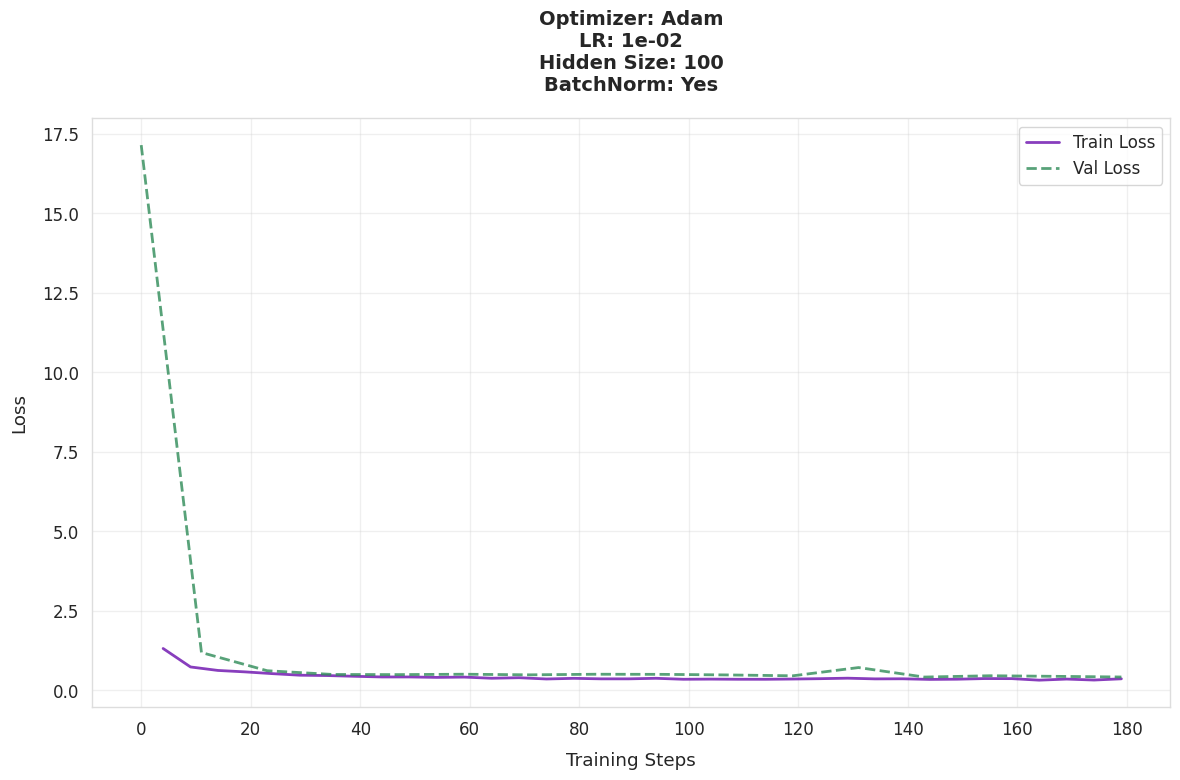

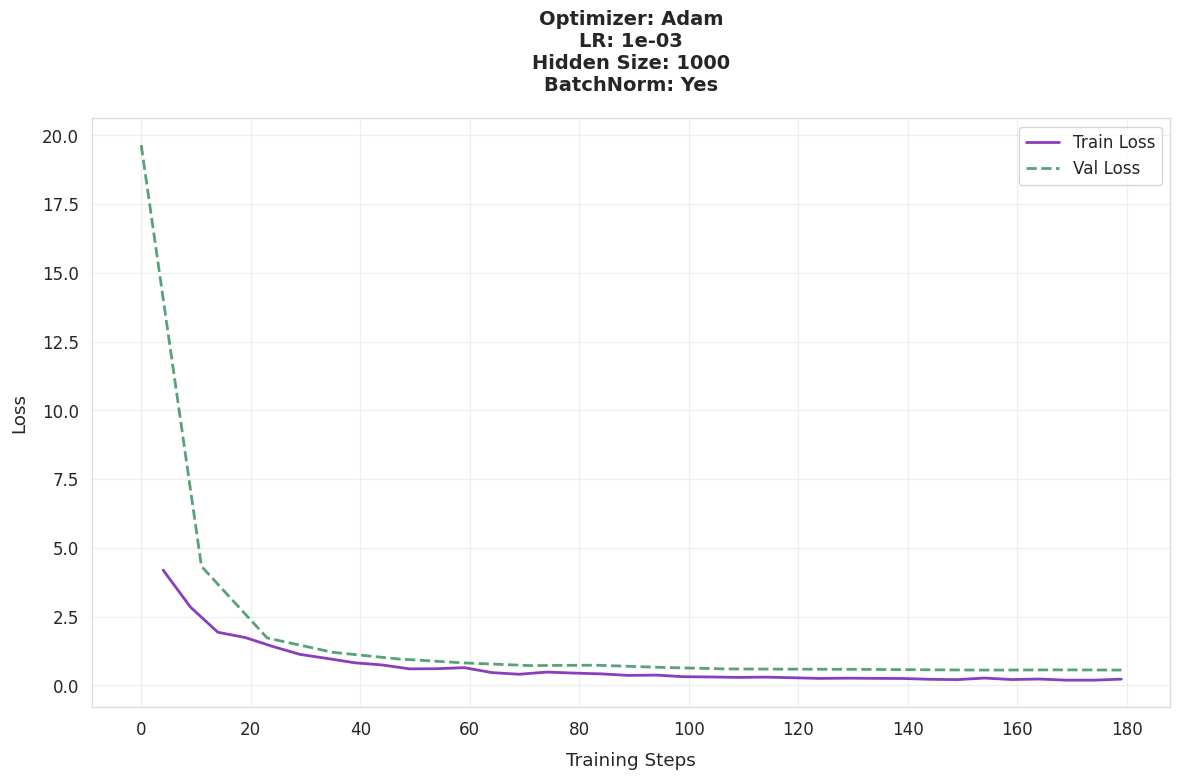

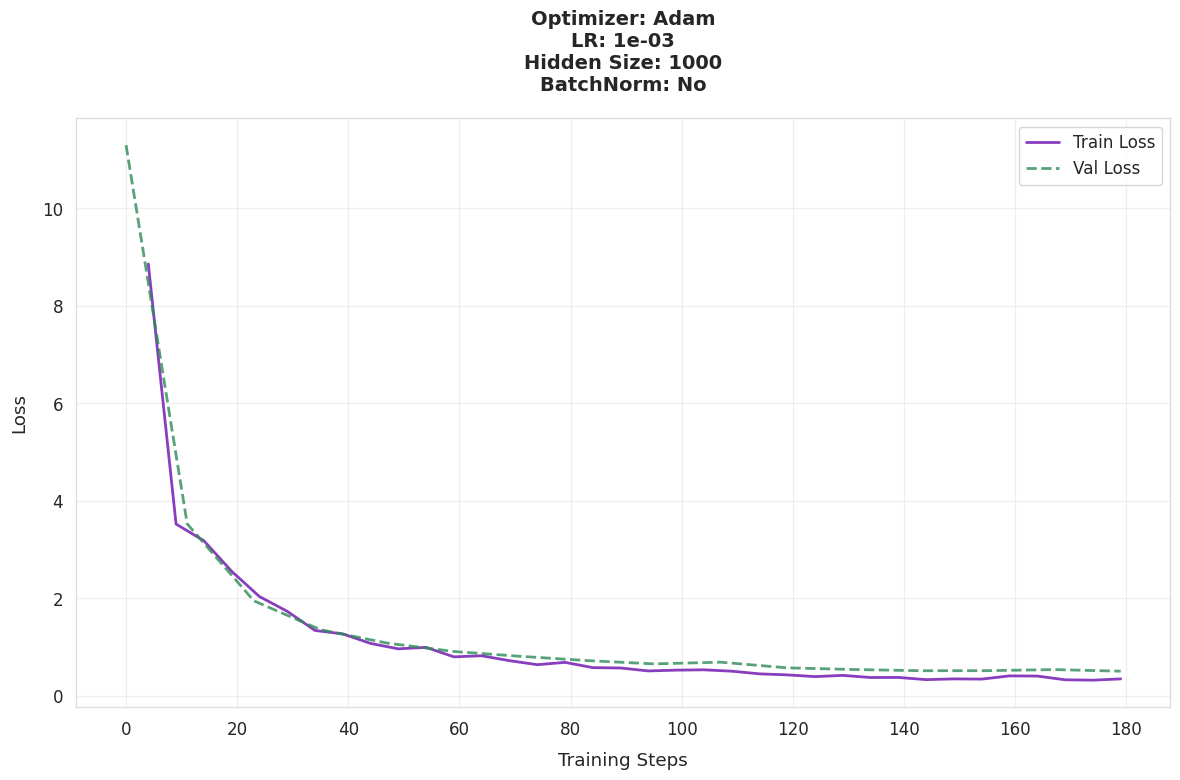

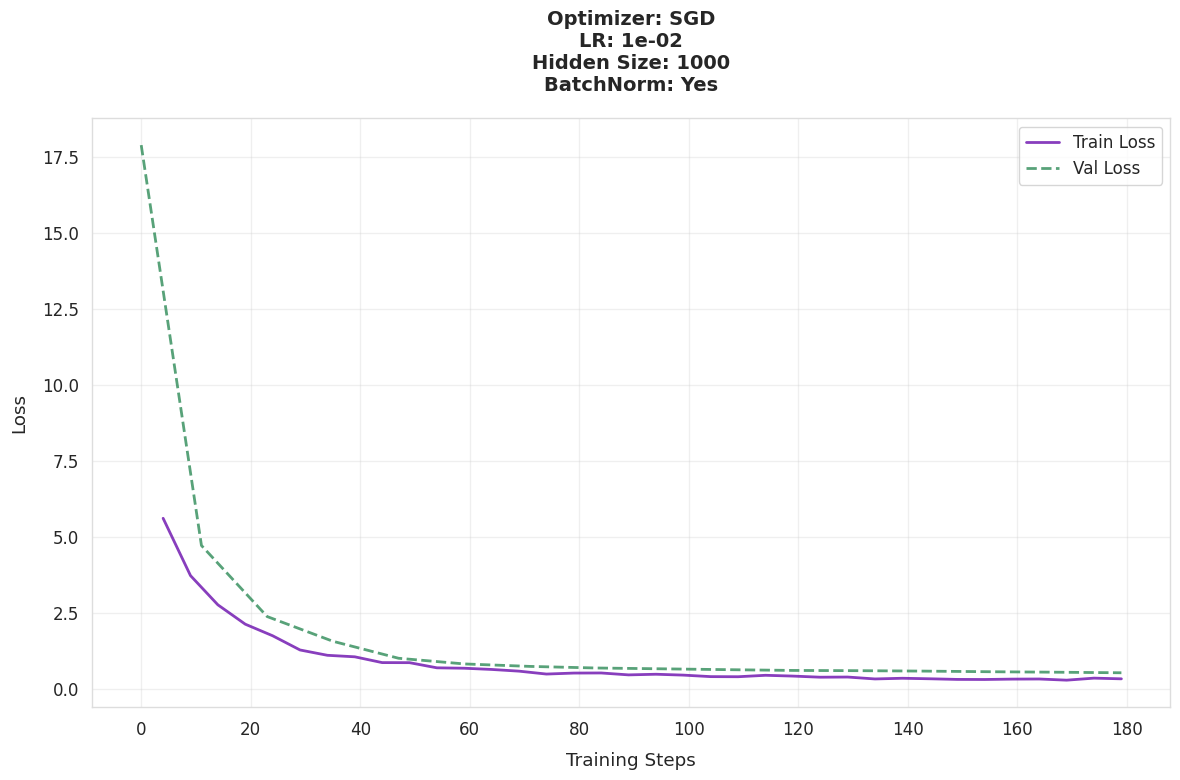

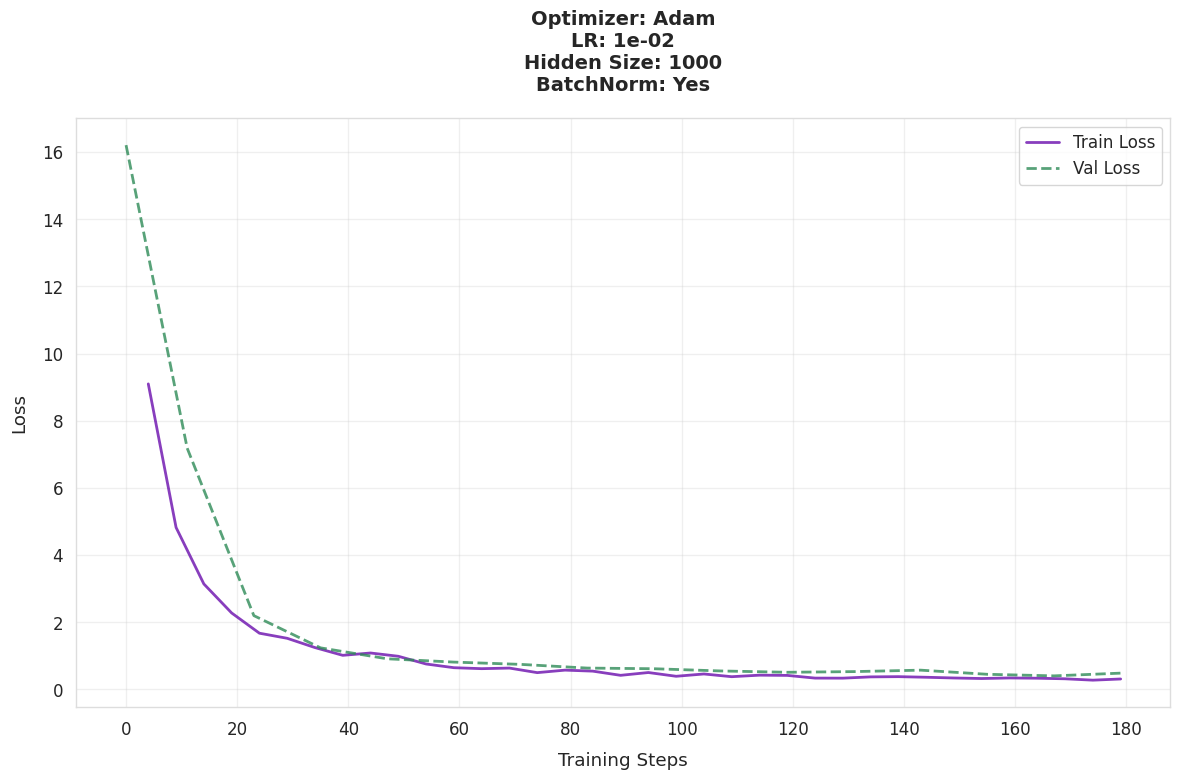


Test Acc Results:
+-----------+---------------+-------------+-----------+----------+
| Optimizer | Learning Rate | Hidden Size | BatchNorm | Test_Acc |
+-----------+---------------+-------------+-----------+----------+
|   Adam    |     1e-02     |     100     |    Yes    |  0.8584  |
|    SGD    |     1e-02     |    1000     |    Yes    |  0.8554  |
|   Adam    |     1e-03     |    1000     |    Yes    |  0.8535  |
|   Adam    |     1e-03     |    1000     |    No     |  0.8441  |
|   Adam    |     1e-02     |    1000     |    Yes    |  0.8158  |
+-----------+---------------+-------------+-----------+----------+


In [196]:
best_versions = glob(f"{LOGGER_DIR}/{RESULT_DIR}/*", recursive=True)
plot_individual_training_results(best_versions)
print_results_table(best_versions, 'test_acc')

### Результаты

В результате, на тестовых данных, лучше всего себя показали комбинации Adam с Learning Rate = 0.01, Hidden Size = 100 и Batch Normalization.